## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
import sys, os
%matplotlib inline

## Camera Calibration

In [2]:
global show_debug_info
show_debug_info = False

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

calib_file_name = 'calib_file.p'


# Define conversions in x and y from pixels space to meters
# unit conversion estimated from image './test_images/unit_conversion.jpg'
ym_per_pix = 3. / 69 # meters per pixel in y dimension
xm_per_pix = 3.7 / 253 # meters per pixel in x dimension

M = []
M_inv = []

./camera_cal/calibration7.jpg
./camera_cal/calibration3.jpg
./camera_cal/calibration10.jpg
./camera_cal/calibration2.jpg
./camera_cal/calibration17.jpg
./camera_cal/calibration20.jpg
./camera_cal/calibration12.jpg
./camera_cal/calibration18.jpg
./camera_cal/calibration4.jpg
./camera_cal/calibration13.jpg
./camera_cal/calibration16.jpg
./camera_cal/calibration11.jpg
./camera_cal/calibration15.jpg
./camera_cal/calibration6.jpg
./camera_cal/calibration8.jpg
./camera_cal/calibration5.jpg
./camera_cal/calibration9.jpg
./camera_cal/calibration1.jpg
./camera_cal/calibration14.jpg
./camera_cal/calibration19.jpg


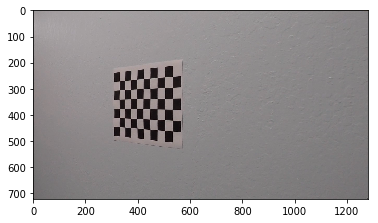

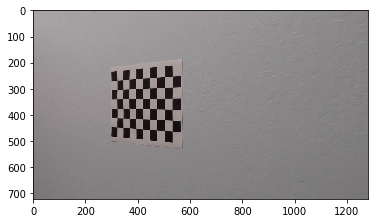

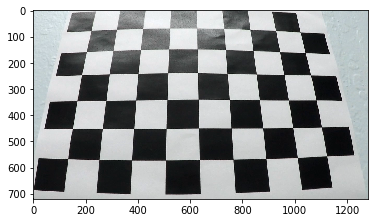

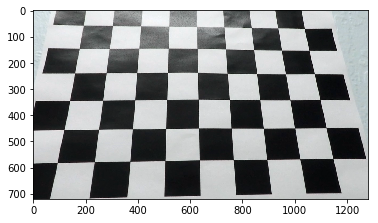

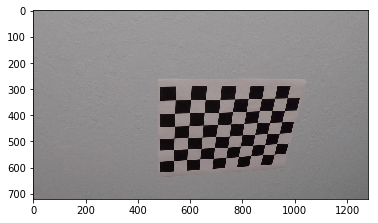

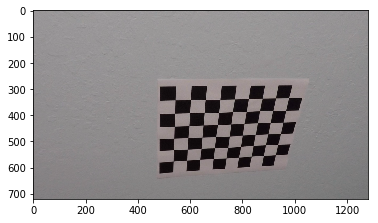

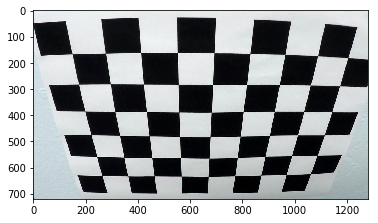

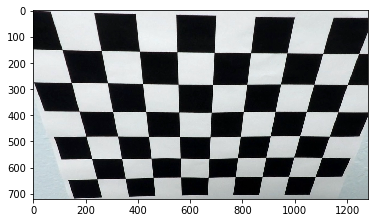

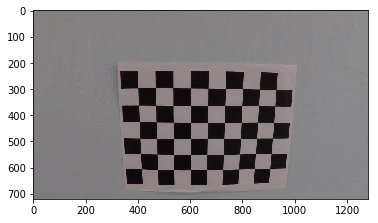

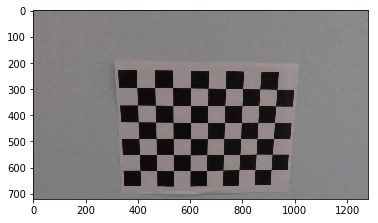

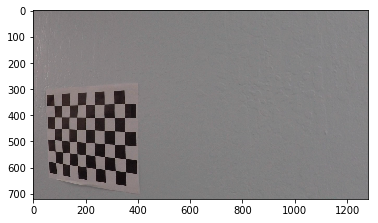

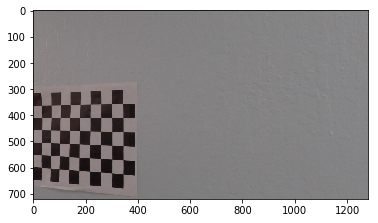

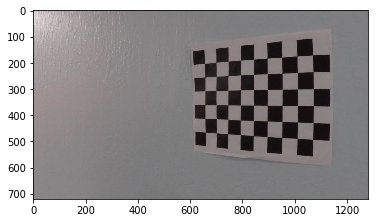

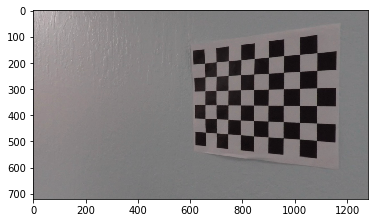

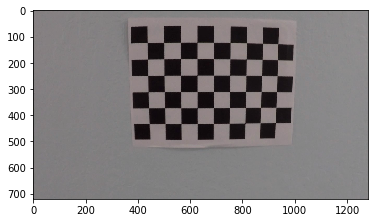

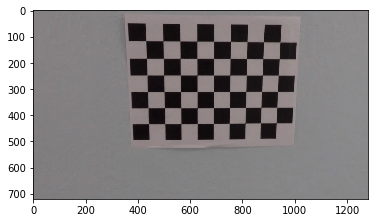

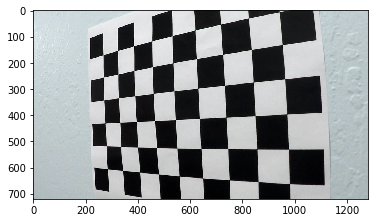

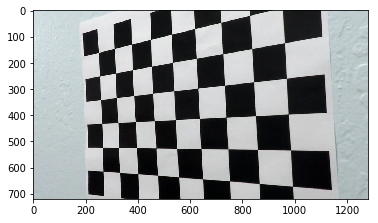

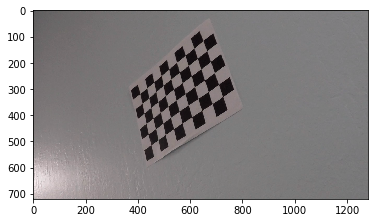

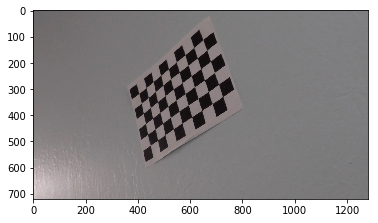

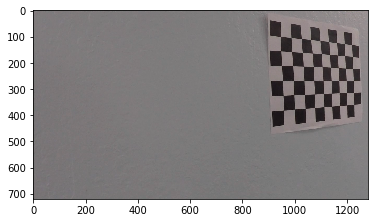

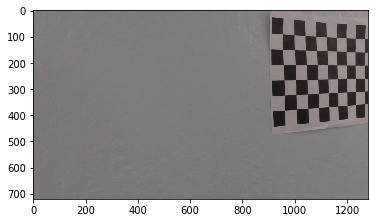

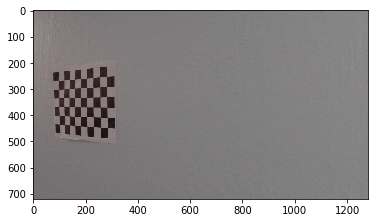

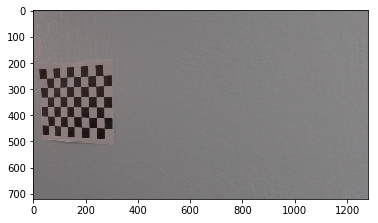

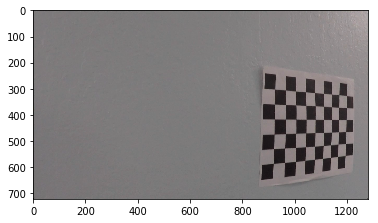

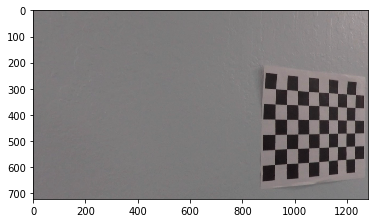

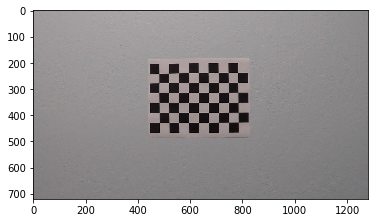

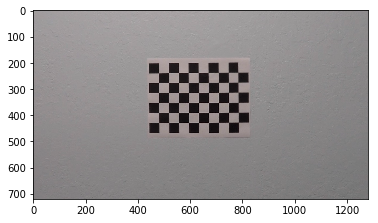

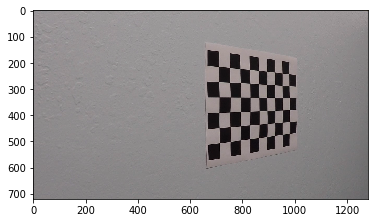

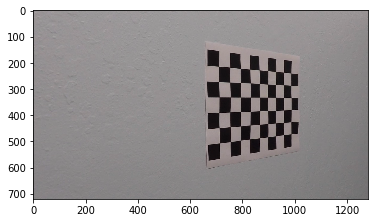

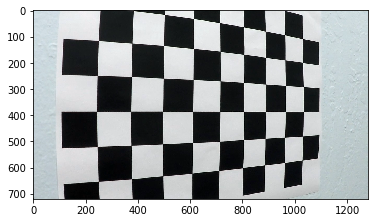

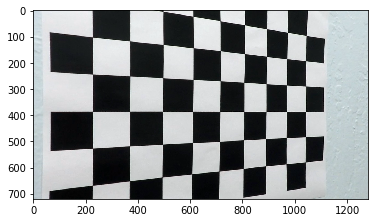

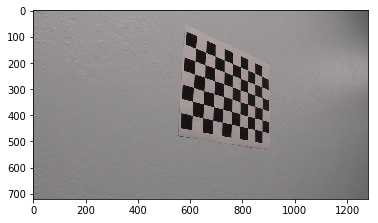

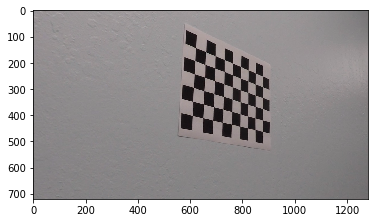

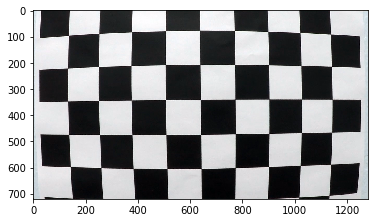

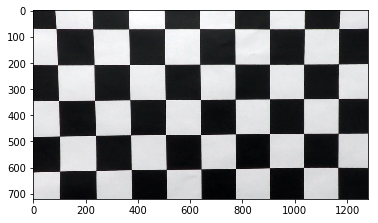

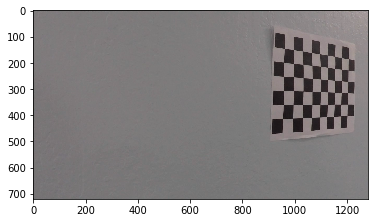

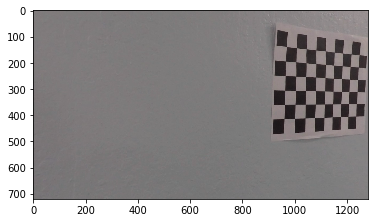

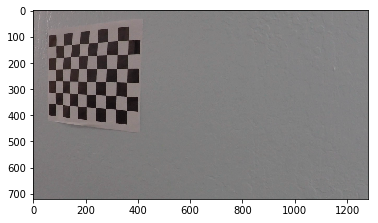

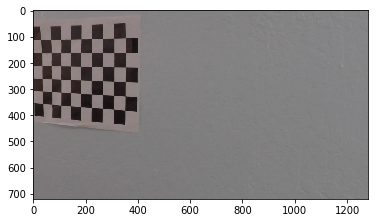

In [3]:
def GenCalibData(nx, ny):
    imgpoints = []
    objpoints = []
    images = []
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:, :2] = np.mgrid[:nx, :ny].T.reshape(-1, 2)
    for file in glob.glob("./camera_cal/calibration*.jpg"):
        print(file)
        img = cv2.imread(file)
        images.append(img)
        img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(img_grey, (nx, ny), None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_grey.shape[::-1], None, None)
    
    for img in images:
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        plt.imshow(img)
        plt.show()
        plt.imshow(undist)
        plt.show()
    
    dict = {'mtx': mtx, 'dist': dist}
    output = open(calib_file_name, 'wb')
    pickle.dump(dict, output)
    output.close()

# Do camera calibration using given images
GenCalibData(nx, ny)

In [4]:
# Load mtx & dist from file
dist_pickle = pickle.load( open( calib_file_name, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
print(mtx)
print(dist)

[[1.15777818e+03 0.00000000e+00 6.67113857e+02]
 [0.00000000e+00 1.15282217e+03 3.86124583e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-0.24688507 -0.02373156 -0.00109831  0.00035107 -0.00259866]]


In [5]:
def DrawInfoOri(img_ori, left_fit, right_fit, M_inv):
    ploty = np.linspace(0, img_ori.shape[0]-1, img_ori.shape[0])
    img_poly = np.zeros_like(img_ori)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(img_poly, np.int_([pts]), (0,255, 0))
    
    cv2.polylines(img_poly, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=15)
    cv2.polylines(img_poly, np.int32([pts_right]), isClosed=False, color=(0,0,255), thickness=15)

    img_size = (cols, rows)
    
    img_poly = cv2.warpPerspective(img_poly, M_inv, img_size, flags=cv2.INTER_LINEAR)
    
    output = cv2.addWeighted(img_ori, 1, img_poly, 0.5, 0)
    
    return output

In [6]:
def CarDeviation(center_x, left_fit, right_fit):
    ploty = img.shape[0]
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
#     print(left_fitx, right_fitx)
    
    if show_debug_info:
        if center_x >= left_fitx and center_x <= right_fitx:
            fit_meanx = float((left_fitx + right_fitx) * 0.5)
            if fit_meanx > center_x:
                print('Car is ' +  str((fit_meanx - center_x) * xm_per_pix) + ' m left to center')
            elif center_x > fit_meanx:
                print('Car is ' +  str((center_x - fit_meanx) * xm_per_pix) + ' m right to center')
            else:
                print('Car is on the center!')
        else:
            print('Car is unknown!!!')

In [7]:
global left_history, right_history
left_history = []
right_history = []
def FindCurvature(left_fit, right_fit, ploty):
    # check history
    dev = 0
    for i in range(len(left_history)):
        dev = dev + np.sum((left_fit - left_history[i]) ** 2) ** 0.5 + np.sum((right_fit - right_history[i]) ** 2) ** 0.5
        
#     print(dev)
    if dev > 10.:
        left_fit = left_history[-1]
        right_fit = right_history[-1]
    left_history.append(left_fit)
    right_history.append(right_fit)
    if len(left_history) > 10:
        left_history.pop(0)
        right_history.pop(0)    
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
#     print(left_curverad, right_curverad)

    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    if show_debug_info:
        print(left_curverad, 'm', right_curverad, 'm')
    
    return left_curverad, right_curverad, left_fitx, right_fitx

In [8]:
def SWS(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
    return out_img, left_fit, right_fit

In [9]:
# Copied from lesson
window_width = 50 
window_height = 50 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def SlidingWindowSearch(warped):
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
        
    return output

In [10]:
def Sobel(img, thresh_min=25, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255. * abs_sobelx / np.max(abs_sobelx))

    # Threshold x gradient
#     thresh_min = 20
#     thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

#     plt.show()
#     plt.imshow(sxbinary)
    
    return sxbinary

In [11]:
# From Project 1
def LineFiltering(img_rgb, color_space):
    if color_space is "HSV":
        # convert image to hsv space
        img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
        (img_h, img_s, img_v) = cv2.split(img_hsv)
        dis_hsv = np.hstack((img_h, img_s, img_v))
        if show_debug_info:
            plt.show()
            plt.title("Images in HSV Color Space")
            plt.imshow(dis_hsv)

        # Filter out lanes in HSV color space
        # yellow lane
        y_lower = np.array([10, 70, 120])
        y_upper = np.array([50, 255, 255])
        img_y = cv2.inRange(img_hsv, y_lower, y_upper)
        if show_debug_info:
            plt.show()
            plt.title("Detection of Yellow Lane in HSV Color Space")
            plt.imshow(img_y)

        # white lane
        w_lower = np.array([0, 0, 200])
        w_upper = np.array([255, 70, 255])
        img_w = cv2.inRange(img_hsv, w_lower, w_upper)
        if show_debug_info:
            plt.show()
            plt.title("Detection of White Lane in HSV Color Space")
            plt.imshow(img_w)
        return cv2.bitwise_or(img_y, img_w)
    elif color_space is "RGB":
        img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        ret, img_gray_th = cv2.threshold(img_gray, 150, 255, cv2.THRESH_BINARY)
        if show_debug_info:
            plt.show()
            plt.title("Detection of Lanes in Gray Image")
            plt.imshow(img_gray_th)
        return img_gray_th
    elif color_space is "HSL":
        # convert image to hsl color space
        img_hls = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)
        (img_h, img_l, img_s) = cv2.split(img_hls)
        dis_hsl = np.hstack((img_h, img_s, img_l))
        if show_debug_info:
            plt.show()
            plt.title("Images in HSL Color Space")
            plt.imshow(dis_hsl)

        # Filter out lanes in HSV color space
        # yellow lane
        y_lower = np.array([10, 100, 100])
        y_upper = np.array([70, 255, 255])
        img_y = cv2.inRange(img_hls, y_lower, y_upper)
        if show_debug_info:
            plt.show()
            plt.title("Detection of Yellow Lane in HSL Color Space")
            plt.imshow(img_y)

        # white lane
        w_lower = np.array([0, 200, 0])
        w_upper = np.array([255, 255, 255])
        img_w = cv2.inRange(img_hls, w_lower, w_upper)
        if show_debug_info:
            plt.show()
            plt.title("Detection of White Lane in HSL Color Space")
            plt.imshow(img_w)
        return cv2.bitwise_or(img_y, img_w)

def FindLineModel(x, y):
    mean_x = sum(x) / len(x)
    mean_y = sum(y) / len(y)
    k = sum((x_i - mean_x) * (y_i - mean_y) for x_i, y_i in zip(x, y)) / sum((x_i - mean_x)**2 for x_i in x)
    m = mean_y - k * mean_x
    
    return k, m
    
import sys
def DistanceFromLine(x, y, l_slope, l_intercept):
    dx = x - (y - l_intercept) / (l_slope + sys.float_info.epsilon)
    dy = y - (l_slope * x + l_intercept)
    
    return math.sqrt(dx**2 + dy**2)
    
def LineFitting(pts):
    n = 3
    num_iter = 20
    thresh = 30
    ratio = 0.6
    error = 1000000
    best_slope = 1
    best_intercept = 0    
    
    if pts.shape[0] < n:
        return FindLineModel(pts[:, 0], pts[:, 1])
    
    for i in range(num_iter):
        rnd_list = np.arange(pts.shape[0])
        np.random.shuffle(rnd_list)
        inlier_maybe = pts[rnd_list[:n]]
        inlier_also = []
        pt_others = pts[rnd_list[n:]]
        
        l_slope, l_intercept = FindLineModel(inlier_maybe[:, 0], inlier_maybe[:, 1])
        
        for pt in pt_others:
            if DistanceFromLine(pt[0], pt[1], l_slope, l_intercept) < thresh:
                inlier_also.append((pt[0], pt[1]))
                
        inlier_also = np.array(inlier_also)
        if inlier_also.shape[0] / pt_others.shape[0] > ratio:
            inlier = np.row_stack((inlier_maybe, inlier_also))
            l_s, l_i = FindLineModel(inlier[:, 0], inlier[:, 1])
            
            err_sum = 0
            for pt in inlier:
                err_sum += DistanceFromLine(pt[0], pt[1], l_s, l_i)
                
            if err_sum < error:
                error = err_sum
                best_slope = l_s
                best_intercept = l_i
        
    return best_slope, best_intercept
    
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [12]:
# Undistort & Transform image
def ImagePreprocess(img, nx, ny, mtx, dist):
    img_undist = cv2.undistort(img, mtx, dist, None, mtx)
    img_undist_grey = cv2.cvtColor(img_undist, cv2.COLOR_BGR2GRAY)
    
    # ROI from Project 1 and adjust roi_y_min to make straight line straight 
    roi_y_min = rows * 0.62
    roi_x_min = cols * 0.45
    roi_x_max = cols * 0.55
    
    pt_src = np.array([
        [0,         rows],
        [roi_x_min, roi_y_min], 
        [roi_x_max, roi_y_min], 
        [cols,   rows]], np.float32)
    ratio_x = 0.35
    pt_dst = np.array([
        [ratio_x * cols,        1.0 * rows],
        [ratio_x * cols,        0.0 * rows],
        [(1. - ratio_x) * cols, 0.0 * rows],
        [(1. - ratio_x) * cols, 1.0 * rows]], np.float32)
    
    M = cv2.getPerspectiveTransform(pt_src, pt_dst)
    M_inv = cv2.getPerspectiveTransform(pt_dst, pt_src)
#     M = np.array(M, np.float64)
#     M_inv = np.array(M_inv, np.float64)
#     print(M)
#     print(M_inv)
    
    img_size = (cols, rows)
#     print(img_size)
    img_warp = cv2.warpPerspective(img_undist, M, img_size, flags=cv2.INTER_LINEAR)
    
    return img_warp, M, M_inv


In [13]:
def Process(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
        
    # Use tuned ROI to filter unrelated stuffs in image under this camera
    # assume strong constraint: car is centered in the lane
    
    rows = img.shape[0]
    cols = img.shape[1]
    
    # image preprocessing (warping, color filter)
    top_down, M, M_inv = ImagePreprocess(img, nx, ny, mtx, dist)
    img_th = LineFiltering(top_down, "HSL")
    
    # Sobel
    img_sobel = np.array(Sobel(top_down, 20, 100), np.uint8)
    # Sobel + color 
    img_comb = cv2.bitwise_or(img_th, img_sobel * 255)
    
    # ROI to filter irrelovant info
    ratio_x = 0.25
    vertices = np.array([[
        (ratio_x * cols,        1.0 * rows),
        (ratio_x * cols,        0.0 * rows),
        ((1. - ratio_x) * cols, 0.0 * rows),
        ((1. - ratio_x) * cols, 1.0 * rows)]], np.int32)
    img_comb = region_of_interest(img_comb, vertices)
    test_images_fil.append(img_comb)
    
    # Sliding window to detect lane line
    ploty = np.linspace(0, img_comb.shape[0]-1, img_comb.shape[0])
    line_detect = SlidingWindowSearch(img_comb)
    out_img, left_fit, right_fit = SWS(img_comb)
    
    # Find curvatures
    left_curverad, right_curverad, left_fitx, right_fitx = FindCurvature(left_fit, right_fit, ploty)

    # check if car is on the center or not
    CarDeviation(img_comb.shape[1] * 0.5, left_fit, right_fit)
    
    img_ori = img.copy()
    img_draw = DrawInfoOri(img_ori, left_fit, right_fit, M_inv)
    
    if show_debug_info:
        f, axes = plt.subplots(2, 5, figsize=(24, 9))
        f.tight_layout()
        font_size = 20
        axes[0, 0].imshow(img)
        axes[0, 0].set_title('Original Image', fontsize=font_size)
        axes[0, 1].imshow(top_down)
        axes[0, 1].set_title('Transformed Image', fontsize=font_size)
        axes[0, 2].imshow(img_th)
        axes[0, 2].set_title("Detection of Lanes", fontsize=font_size)
        axes[0, 3].imshow(img_sobel)
        axes[0, 3].set_title("Sobel X", fontsize=font_size)
        axes[0, 4].imshow(img_comb)
        axes[0, 4].set_title("Combination", fontsize=font_size)
        axes[1, 0].imshow(out_img)
        axes[1, 0].plot(left_fitx, ploty, color='yellow')
        axes[1, 0].plot(right_fitx, ploty, color='yellow')
        axes[1, 1].imshow(line_detect)
        axes[1, 1].set_title("Detection", fontsize=font_size)
        axes[1, 2].imshow(img_draw)

        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
    return img_draw

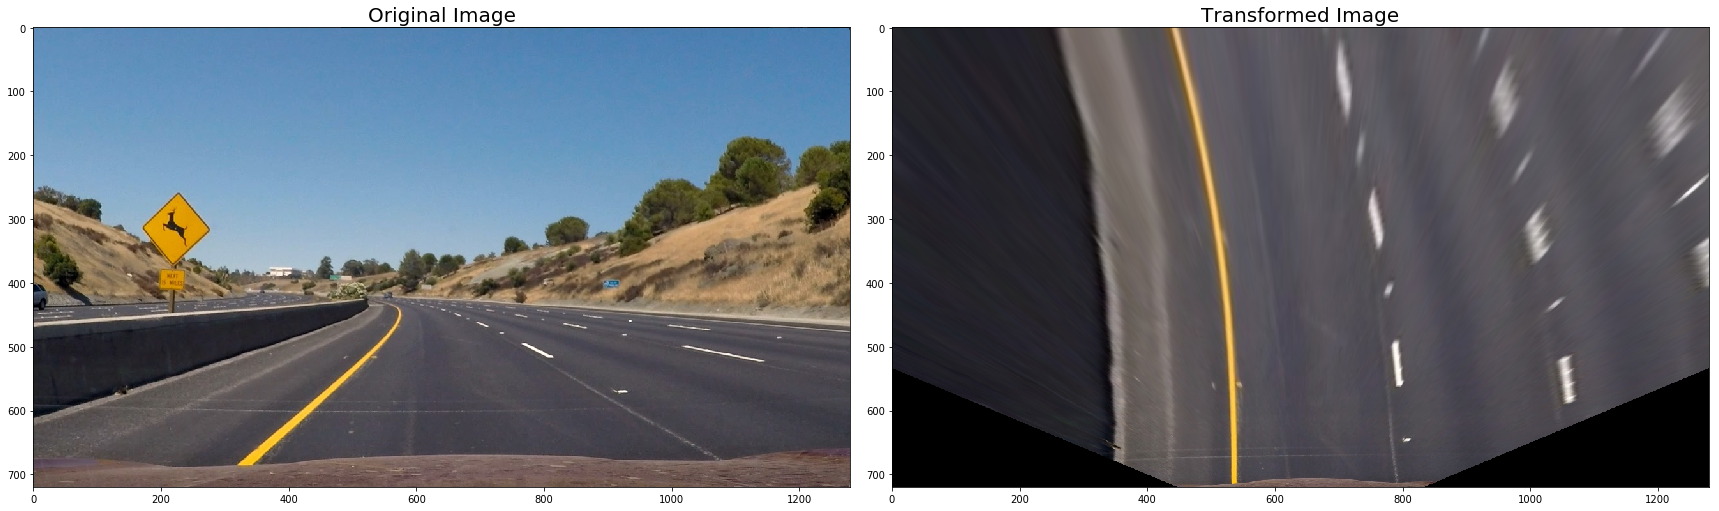

In [14]:
test_images = []
global rows, cols
for file in glob.glob("./test_images/*.jpg"):
    img = cv2.imread(file)
    rows = img.shape[0]
    cols = img.shape[1]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    test_images.append(img)
    
    top_down, M, M_inv = ImagePreprocess(img, nx, ny, mtx, dist)
    
    f, axes = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    font_size = 20
    axes[0].imshow(img)
    axes[0].set_title('Original Image', fontsize=font_size)
    axes[1].imshow(top_down)
    axes[1].set_title('Transformed Image', fontsize=font_size)
    
#     cv2.imwrite("./test_images/t.jpg", top_down)
    break

test_images_fil = []

In [15]:
for img in test_images:
    Process(img)

0


---

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
output_dir = 'test_videos_output/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [18]:
video_name = 'project_video.mp4'
white_output = output_dir + video_name
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
## clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./" + video_name)
white_clip = clip1.fl_image(Process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

15.147299294085103
[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


  0%|          | 1/1261 [00:00<02:23,  8.75it/s]

30.294598588170203


  0%|          | 2/1261 [00:00<02:40,  7.87it/s]

14.696143549299256


  0%|          | 3/1261 [00:00<02:30,  8.36it/s]

37.56916992243644
58.17933010330331


  0%|          | 5/1261 [00:00<02:17,  9.16it/s]

66.54853568096593


  0%|          | 6/1261 [00:00<02:14,  9.30it/s]

81.76005536611169
70.83295151893245


  1%|          | 8/1261 [00:00<02:07,  9.79it/s]

91.70778842527025


  1%|          | 9/1261 [00:00<02:08,  9.76it/s]

59.11856373731126
64.97431017196008


  1%|          | 12/1261 [00:01<02:04, 10.06it/s]

62.17252905889891
85.40299701656313
26.86487821597659


  1%|▏         | 16/1261 [00:01<01:51, 11.14it/s]

106.98499147706114
327.59969611388163
404.6369486803603


  1%|▏         | 18/1261 [00:01<01:48, 11.43it/s]

450.6358315651586
497.74858699148416
431.7409135196794


  2%|▏         | 22/1261 [00:02<01:45, 11.72it/s]

370.3243102796529
293.48557762292086
230.629382641622


  2%|▏         | 24/1261 [00:02<01:42, 12.03it/s]

164.63684307909756
224.9603762635886
257.78679781362774


  2%|▏         | 28/1261 [00:02<01:43, 11.90it/s]

157.53237908630382
150.94916655053714
181.36074671977508


  2%|▏         | 30/1261 [00:02<01:43, 11.84it/s]

180.93682015481875
338.1220970680005
424.97351199953744


  3%|▎         | 34/1261 [00:03<01:45, 11.63it/s]

535.8341583066671
445.19709069321596
474.4851392058017


  3%|▎         | 36/1261 [00:03<01:44, 11.73it/s]

525.6543169560535
622.1964332873956
662.2208262153787


  3%|▎         | 40/1261 [00:03<01:45, 11.57it/s]

694.0168045608034
819.0997461160371
787.5676626526453


  3%|▎         | 42/1261 [00:03<01:43, 11.76it/s]

793.3750483337683
780.2557959531089


  3%|▎         | 44/1261 [00:04<02:05,  9.67it/s]

730.2931733342784
630.6600941738176


  4%|▎         | 46/1261 [00:04<02:03,  9.80it/s]

560.4442750606157
531.8232810950939
480.1733843288651


  4%|▍         | 49/1261 [00:04<02:16,  8.88it/s]

523.4991770280914
433.9734505326076


  4%|▍         | 51/1261 [00:04<02:25,  8.33it/s]

468.05758617595944
501.9566368087101


  4%|▍         | 53/1261 [00:05<02:32,  7.92it/s]

605.3363373218417
616.3627259793323


  4%|▍         | 55/1261 [00:05<02:38,  7.63it/s]

621.0570790622564
593.5187167788793


  5%|▍         | 57/1261 [00:05<02:40,  7.48it/s]

549.3221358678863
525.8988497561683


  5%|▍         | 59/1261 [00:05<02:41,  7.42it/s]

465.78024769882626
651.6297490858536


  5%|▍         | 60/1261 [00:06<02:33,  7.81it/s]

1124.4745047708118
1130.2889341268494


  5%|▍         | 63/1261 [00:06<02:29,  8.03it/s]

1301.388044623761
1124.0236641995127


  5%|▌         | 65/1261 [00:06<02:36,  7.66it/s]

1344.5319735762573
1013.9427900001209


  5%|▌         | 67/1261 [00:06<02:31,  7.88it/s]

637.8410015677422
617.7443635733474


  5%|▌         | 69/1261 [00:07<02:21,  8.42it/s]

559.3817549608251
638.5272540082592


  6%|▌         | 71/1261 [00:07<02:19,  8.54it/s]

524.8188692848494
560.8189602533301


  6%|▌         | 73/1261 [00:07<02:28,  8.00it/s]

518.7549428292651
498.7001549456822


  6%|▌         | 75/1261 [00:07<02:27,  8.03it/s]

489.6873549475522
430.68138158568286


  6%|▌         | 77/1261 [00:08<02:38,  7.45it/s]

450.507515859327
336.00402407174647


  6%|▋         | 79/1261 [00:08<02:26,  8.08it/s]

279.13557567891473
501.8454900195053


  6%|▋         | 81/1261 [00:08<02:21,  8.36it/s]

812.213625582822
661.6535367489355


  7%|▋         | 83/1261 [00:08<02:25,  8.07it/s]

695.5724793521116
524.3431393708739


  7%|▋         | 85/1261 [00:09<02:17,  8.53it/s]

2027.3358655713198
94.627278396051
81.31246013808838


  7%|▋         | 88/1261 [00:09<02:23,  8.17it/s]

279.49287250882446
386.75779692786364


  7%|▋         | 90/1261 [00:09<02:25,  8.03it/s]

462.9111587488395
567.5111241211989


  7%|▋         | 92/1261 [00:09<02:33,  7.61it/s]

479.50649973894315
445.04187543936155


  7%|▋         | 93/1261 [00:10<02:27,  7.93it/s]

503.3537376412902
533.9876355399352


  8%|▊         | 97/1261 [00:10<02:12,  8.80it/s]

422.7395504257974
452.3042213406276
454.3750117094718


  8%|▊         | 99/1261 [00:10<02:11,  8.82it/s]

382.97938672853
476.2067307152281


  8%|▊         | 101/1261 [00:11<02:24,  8.02it/s]

410.4588496328586
457.3019196330448


  8%|▊         | 103/1261 [00:11<02:24,  8.01it/s]

507.1564478827943
463.0906400735941


  8%|▊         | 105/1261 [00:11<02:32,  7.57it/s]

458.88222747021376
358.5110914293187


  8%|▊         | 107/1261 [00:11<02:33,  7.51it/s]

303.07662184622086
226.95206037964022


  9%|▊         | 108/1261 [00:11<02:32,  7.57it/s]

280.82381916025895
312.49284033579823
329.683955456383


  9%|▉         | 112/1261 [00:12<02:16,  8.39it/s]

435.8894791212596
222.81930734518656


  9%|▉         | 114/1261 [00:12<02:22,  8.03it/s]

439.6384303953563
416.0248122630628


  9%|▉         | 116/1261 [00:12<02:21,  8.11it/s]

574.2630646680859
570.110532708447


  9%|▉         | 118/1261 [00:13<02:27,  7.73it/s]

517.0486011677843
549.6041562925956


 10%|▉         | 120/1261 [00:13<02:28,  7.69it/s]

549.6053605174116
627.5510843966389


 10%|▉         | 122/1261 [00:13<02:24,  7.90it/s]

592.5120101693401
616.6741935050081


 10%|▉         | 124/1261 [00:13<02:26,  7.77it/s]

651.3907403284759
658.1515482721667


 10%|▉         | 126/1261 [00:14<02:35,  7.29it/s]

661.744276627968
527.0101595902254


 10%|█         | 128/1261 [00:14<02:18,  8.20it/s]

579.9899023181027
512.6634063332637


 10%|█         | 130/1261 [00:14<02:24,  7.83it/s]

636.8796856736542
575.8720440885896


 10%|█         | 132/1261 [00:14<02:25,  7.75it/s]

595.3952280233995
629.4720636786611


 11%|█         | 134/1261 [00:15<02:18,  8.16it/s]

539.4376819215753
553.3461138733195


 11%|█         | 135/1261 [00:15<02:21,  7.96it/s]

488.53946591649236
412.49163262723795


 11%|█         | 138/1261 [00:15<02:23,  7.85it/s]

348.9899036465222
285.3516408127384


 11%|█         | 140/1261 [00:15<02:23,  7.82it/s]

257.560423839356
177.18112919627677


 11%|█▏        | 142/1261 [00:16<02:23,  7.78it/s]

224.2552559563694
193.9769842014662


 11%|█▏        | 144/1261 [00:16<02:11,  8.52it/s]

275.1650595481959
248.63317842761717


 12%|█▏        | 146/1261 [00:16<02:21,  7.89it/s]

227.49783871945863
232.62107366114174


 12%|█▏        | 148/1261 [00:16<02:20,  7.95it/s]

251.62722742870042
396.9220446388567


 12%|█▏        | 150/1261 [00:17<02:14,  8.26it/s]

400.35462169317003
317.2503146401135


 12%|█▏        | 152/1261 [00:17<02:19,  7.96it/s]

290.43274956925956
298.6540191054247


 12%|█▏        | 153/1261 [00:17<02:22,  7.78it/s]

367.62530226823606
277.98091274961894


 12%|█▏        | 156/1261 [00:17<02:20,  7.85it/s]

250.06460737555926
247.63648890402177


 13%|█▎        | 158/1261 [00:18<02:20,  7.83it/s]

277.6343560833755
466.89552092907405


 13%|█▎        | 161/1261 [00:18<02:05,  8.78it/s]

481.3383634774277
588.6133507780404
507.5018479500567


 13%|█▎        | 163/1261 [00:18<02:14,  8.13it/s]

504.8502375986767
464.0250091532198


 13%|█▎        | 165/1261 [00:18<02:07,  8.58it/s]

571.324729105338
760.2341952829574


 13%|█▎        | 167/1261 [00:19<02:07,  8.57it/s]

754.2812193713371
941.6190324929132


 13%|█▎        | 169/1261 [00:19<02:11,  8.29it/s]

760.8827160802321
729.5381508827074


 14%|█▎        | 171/1261 [00:19<02:16,  7.97it/s]

639.4116462140527
649.1661832094372


 14%|█▎        | 172/1261 [00:19<02:22,  7.65it/s]

742.0454034676259
855.1748511848447


 14%|█▍        | 176/1261 [00:20<02:01,  8.93it/s]

1023.5489576275713
1085.7365483819854
1212.2766688458398


 14%|█▍        | 178/1261 [00:20<02:03,  8.77it/s]

1032.2995623478573
993.7976775701169


 14%|█▍        | 180/1261 [00:20<01:59,  9.06it/s]

971.4527190213381
893.479372069325


 14%|█▍        | 182/1261 [00:20<02:04,  8.67it/s]

985.5380182821248
867.4677572405474


 15%|█▍        | 184/1261 [00:21<02:04,  8.66it/s]

966.3180928349763
1045.8522710977059


 15%|█▍        | 185/1261 [00:21<02:13,  8.07it/s]

1113.7664743943067
1398.005202523328


 15%|█▍        | 188/1261 [00:21<02:06,  8.49it/s]

1442.6378637303806
1510.5745284783218


 15%|█▌        | 190/1261 [00:21<02:17,  7.81it/s]

1444.7864569587841
1443.9317101564432


 15%|█▌        | 192/1261 [00:22<02:13,  7.98it/s]

1434.0636450015177
1350.6249532964034


 15%|█▌        | 194/1261 [00:22<02:22,  7.47it/s]

1443.8189747201343
1345.2033536986637


 16%|█▌        | 196/1261 [00:22<02:19,  7.65it/s]

1318.5382188806511
987.4091087230473


 16%|█▌        | 198/1261 [00:22<02:21,  7.50it/s]

658.1199930732677
444.6732935141447


 16%|█▌        | 200/1261 [00:23<02:20,  7.53it/s]

278.1997552153932
359.1945055684419


 16%|█▌        | 202/1261 [00:23<02:08,  8.21it/s]

305.5679655446734
492.9679646998257
585.1171342607882


 16%|█▌        | 204/1261 [00:23<02:08,  8.19it/s]

607.711443631625
693.6995068097547


 16%|█▋        | 207/1261 [00:23<01:59,  8.81it/s]

701.4442968376337
881.0599832980514


 17%|█▋        | 209/1261 [00:24<02:05,  8.41it/s]

958.0313841975587
861.0414434992981


 17%|█▋        | 212/1261 [00:24<01:58,  8.87it/s]

763.2977068184414
557.7918777247841
641.6786357795685


 17%|█▋        | 214/1261 [00:24<02:09,  8.10it/s]

634.6586433825312
725.9887205136856


 17%|█▋        | 216/1261 [00:25<02:10,  8.00it/s]

752.3346727774318
752.1420840332277


 17%|█▋        | 218/1261 [00:25<02:15,  7.71it/s]

782.128541415473
686.9305277760449


 17%|█▋        | 220/1261 [00:25<02:20,  7.42it/s]

816.8570313034602
686.7499792769361


 18%|█▊        | 221/1261 [00:25<02:12,  7.85it/s]

678.8210237036568
707.8457210986735


 18%|█▊        | 224/1261 [00:26<02:10,  7.93it/s]

685.870026207989
872.918814297161


 18%|█▊        | 226/1261 [00:26<02:06,  8.16it/s]

820.9474116540334
933.9132774278522


 18%|█▊        | 227/1261 [00:26<02:09,  7.97it/s]

890.4018780662533
829.7456964924204


 18%|█▊        | 230/1261 [00:26<02:05,  8.21it/s]

834.4575430960401
733.5428057249455


 18%|█▊        | 232/1261 [00:26<01:57,  8.74it/s]

799.5115904643391
721.4917061665873


 19%|█▊        | 234/1261 [00:27<02:00,  8.53it/s]

780.4943748271521
808.088500080746
860.7531585758342


 19%|█▊        | 236/1261 [00:27<01:55,  8.89it/s]

1018.3472447193892
1009.4008622478535


 19%|█▉        | 239/1261 [00:27<01:54,  8.93it/s]

1146.2660791029716
1016.6613575480948


 19%|█▉        | 241/1261 [00:28<01:59,  8.54it/s]

1016.0862440628953
969.4978155082757


 19%|█▉        | 243/1261 [00:28<02:06,  8.08it/s]

1026.8067390804185
1179.7202605801522


 20%|█▉        | 246/1261 [00:28<01:55,  8.80it/s]

1084.6630390860264
1195.9400019754412
1200.1167176289796


 20%|█▉        | 248/1261 [00:28<02:01,  8.34it/s]

1131.8284025989399
1300.5430978427112


 20%|█▉        | 250/1261 [00:29<01:59,  8.43it/s]

1147.1964812172473
1214.3612338857097


 20%|█▉        | 252/1261 [00:29<01:59,  8.45it/s]

1114.3769959864892
1036.3588449287115


 20%|██        | 254/1261 [00:29<02:03,  8.17it/s]

1003.769388134189
884.6903444982566


 20%|██        | 256/1261 [00:29<01:57,  8.54it/s]

945.1974594440536
878.9034498805198


 20%|██        | 258/1261 [00:30<02:04,  8.04it/s]

862.5392778423808
835.7023659280412


 21%|██        | 260/1261 [00:30<02:02,  8.19it/s]

744.4793238101897
766.1367705014903


 21%|██        | 262/1261 [00:30<02:04,  8.03it/s]

586.1530648249836
574.8008559554418


 21%|██        | 264/1261 [00:30<02:03,  8.05it/s]

511.94118557337106
456.8725702677118


 21%|██        | 266/1261 [00:31<02:10,  7.60it/s]

396.8971851265143
307.835369546014


 21%|██▏       | 268/1261 [00:31<02:01,  8.15it/s]

334.2065859768114
252.29637065346316


 21%|██▏       | 270/1261 [00:31<02:05,  7.88it/s]

159.07342299188448
215.08702362334213


 22%|██▏       | 272/1261 [00:31<02:00,  8.18it/s]

274.9108333927165
375.60978446170355


 22%|██▏       | 274/1261 [00:32<01:59,  8.25it/s]

378.65209659822324
530.5732400389954


 22%|██▏       | 276/1261 [00:32<02:06,  7.80it/s]

484.0025580653027
391.2917626307324


 22%|██▏       | 278/1261 [00:32<02:09,  7.61it/s]

342.082230940807
279.2969972928199


 22%|██▏       | 280/1261 [00:32<01:56,  8.41it/s]

402.30904631533576
393.95566704786006


 22%|██▏       | 282/1261 [00:33<01:58,  8.27it/s]

391.4547849332404
415.6966872013044


 23%|██▎       | 284/1261 [00:33<02:01,  8.05it/s]

348.11968950804516
376.31783701976053


 23%|██▎       | 286/1261 [00:33<02:03,  7.86it/s]

318.1130814133945
375.76981267619374


 23%|██▎       | 288/1261 [00:33<02:07,  7.60it/s]

438.4143571531617
499.4347567345591


 23%|██▎       | 290/1261 [00:34<02:07,  7.62it/s]

488.4014698074729
555.4631473470998


 23%|██▎       | 292/1261 [00:34<02:06,  7.66it/s]

511.5942999571627
531.7723561105973


 23%|██▎       | 294/1261 [00:34<01:59,  8.12it/s]

588.9510675885468
612.3285595883215


 23%|██▎       | 296/1261 [00:34<02:01,  7.96it/s]

658.0440100930176
665.6865577399354


 24%|██▎       | 298/1261 [00:35<01:53,  8.47it/s]

719.0308379252917
737.8204395408687


 24%|██▍       | 300/1261 [00:35<01:53,  8.50it/s]

744.5647658521618
779.4745078767013


 24%|██▍       | 301/1261 [00:35<01:51,  8.61it/s]

766.5781392722992
818.1099193750889


 24%|██▍       | 304/1261 [00:35<01:48,  8.82it/s]

827.0209876505229
850.2052107465126
912.7597925549799


 24%|██▍       | 307/1261 [00:36<01:46,  8.97it/s]

892.5577162351206
958.7583444910443


 25%|██▍       | 309/1261 [00:36<01:57,  8.11it/s]

975.5466171358112
1043.3239704093392


 25%|██▍       | 310/1261 [00:36<01:58,  8.02it/s]

1055.9092821442255
1047.7441748506737


 25%|██▍       | 313/1261 [00:36<01:51,  8.49it/s]

1075.4497120811902
1089.9125412814271
1151.2656190021614


 25%|██▌       | 316/1261 [00:37<01:57,  8.06it/s]

1197.7763283321406
1252.3766032628837


 25%|██▌       | 318/1261 [00:37<01:49,  8.59it/s]

1320.583020635248
1340.1386037039872


 25%|██▌       | 321/1261 [00:37<01:43,  9.12it/s]

1383.191710755884
1361.171353028708
1411.435759387982


 26%|██▌       | 323/1261 [00:37<01:51,  8.42it/s]

1423.2828029070263
1460.7037512637542


 26%|██▌       | 325/1261 [00:38<01:54,  8.18it/s]

1496.374644004843
1502.9328224370142
1491.384798910241


 26%|██▌       | 328/1261 [00:38<01:51,  8.39it/s]

1536.4363179418137
1547.093054481562


 26%|██▌       | 330/1261 [00:38<01:59,  7.80it/s]

1633.266101453255
1625.4144446256375


 26%|██▋       | 332/1261 [00:39<01:59,  7.80it/s]

1648.881509320477
1611.7639308490877


 26%|██▋       | 334/1261 [00:39<01:59,  7.78it/s]

1584.8433235835967
1590.87392245283


 27%|██▋       | 335/1261 [00:39<01:56,  7.96it/s]

1599.4172653322087
1684.2851160053435


 27%|██▋       | 338/1261 [00:39<01:48,  8.54it/s]

1660.6184115285284
1674.198241870688


 27%|██▋       | 340/1261 [00:40<01:52,  8.22it/s]

1661.0309235524835
1654.251612208061


 27%|██▋       | 342/1261 [00:40<01:51,  8.25it/s]

1668.0208713996421
1549.27276994366
1674.589246631181


 27%|██▋       | 345/1261 [00:40<01:49,  8.38it/s]

1670.477068139635
1672.9851504208727


 28%|██▊       | 347/1261 [00:40<01:44,  8.74it/s]

1686.1228826003537
1660.3805317365277


 28%|██▊       | 349/1261 [00:41<01:52,  8.13it/s]

1688.3884052625615
1645.0529115139884


 28%|██▊       | 351/1261 [00:41<01:53,  8.05it/s]

1669.2175543761186
1658.0302857082233


 28%|██▊       | 353/1261 [00:41<01:54,  7.91it/s]

1666.9407081729812
1706.9132698128396


 28%|██▊       | 355/1261 [00:41<01:52,  8.03it/s]

1717.9860693551025
1735.6109391366024


 28%|██▊       | 357/1261 [00:42<01:55,  7.81it/s]

1743.1992156923438
1772.072397061227


 28%|██▊       | 359/1261 [00:42<01:45,  8.53it/s]

1803.0924922590953
1812.6148420874


 29%|██▊       | 361/1261 [00:42<01:41,  8.91it/s]

1806.2633827464915
1845.87510403139


 29%|██▊       | 362/1261 [00:42<01:40,  8.94it/s]

1815.3034118688026
1859.6038280448035
1874.1724072844172


 29%|██▉       | 366/1261 [00:43<01:45,  8.52it/s]

1923.7586512405069
1935.8192142217104


 29%|██▉       | 368/1261 [00:43<01:51,  7.98it/s]

1956.950834759423
1968.345519837767


 29%|██▉       | 370/1261 [00:43<01:48,  8.24it/s]

1971.274321208755
1980.2250870062765


 30%|██▉       | 372/1261 [00:43<01:43,  8.63it/s]

1960.5820738500233
1943.608480905698


 30%|██▉       | 374/1261 [00:44<01:50,  8.01it/s]

1926.6273634719505
1917.990854410713


 30%|██▉       | 376/1261 [00:44<01:47,  8.24it/s]

1871.4608868248563
1828.9738063620655


 30%|██▉       | 378/1261 [00:44<01:52,  7.88it/s]

1879.8888020492586
1870.258279000246


 30%|███       | 380/1261 [00:44<01:53,  7.74it/s]

1881.8806147880878
1879.988123362919


 30%|███       | 382/1261 [00:45<02:01,  7.25it/s]

1882.3214334687034
1887.309622882022


 30%|███       | 384/1261 [00:45<01:55,  7.56it/s]

1872.631508686679
1871.7684769744126


 31%|███       | 386/1261 [00:45<01:50,  7.90it/s]

1845.667851724231
1827.482991582337


 31%|███       | 388/1261 [00:45<01:51,  7.86it/s]

1823.966230131041
1811.5051704895768


 31%|███       | 390/1261 [00:46<01:51,  7.83it/s]

1817.5260067538634
1820.6220743258507


 31%|███       | 392/1261 [00:46<01:52,  7.72it/s]

1839.8283165343794
1807.3258352234395


 31%|███       | 394/1261 [00:46<01:45,  8.19it/s]

1758.5558268068462
1751.2288456129722


 31%|███▏      | 396/1261 [00:46<01:49,  7.88it/s]

1687.8343794624707
1679.6265245105133


 32%|███▏      | 398/1261 [00:47<01:54,  7.51it/s]

1667.0132062533287
1644.7732382648594


 32%|███▏      | 400/1261 [00:47<01:53,  7.58it/s]

1666.0955760146808
1678.8020512423882


 32%|███▏      | 403/1261 [00:47<01:37,  8.83it/s]

1712.3505702191335
1726.0246345225576
1736.9933259040408


 32%|███▏      | 404/1261 [00:47<01:46,  8.01it/s]

1736.9943829003073
1701.1193873824316


 32%|███▏      | 407/1261 [00:48<02:16,  6.23it/s]

1715.6532690744646
1719.0912520958684


 32%|███▏      | 409/1261 [00:48<02:07,  6.67it/s]

1669.4786633268152
1617.5259224681956


 33%|███▎      | 411/1261 [00:48<01:54,  7.40it/s]

1590.2380810027637
1594.582519914777


 33%|███▎      | 413/1261 [00:49<02:05,  6.75it/s]

1596.3571944596213
1625.406173762606


 33%|███▎      | 414/1261 [00:49<01:55,  7.33it/s]

1637.811391334476
1626.3217114517813


 33%|███▎      | 417/1261 [00:49<01:45,  8.00it/s]

1630.3808788392762
1602.7359027854504


 33%|███▎      | 420/1261 [00:50<01:39,  8.43it/s]

1583.5458019735484
1545.9182457906675
1503.5711889298034


 33%|███▎      | 422/1261 [00:50<01:41,  8.23it/s]

1495.9601266432933
1478.1888199465682


 34%|███▎      | 424/1261 [00:50<01:43,  8.06it/s]

1485.979067416803
1486.3474213031673


 34%|███▎      | 425/1261 [00:50<01:47,  7.77it/s]

1571.646528973663
1557.9433675451594


 34%|███▍      | 427/1261 [00:50<01:43,  8.07it/s]

1544.8928421732921
1535.907078560248


 34%|███▍      | 430/1261 [00:51<01:53,  7.31it/s]

1495.7660806413005
1474.3506391490623


 34%|███▍      | 432/1261 [00:51<01:48,  7.65it/s]

1468.3345190148666
1448.5633905542054


 34%|███▍      | 434/1261 [00:51<01:46,  7.79it/s]

1451.5662800589225
1439.8338991435282


 34%|███▍      | 435/1261 [00:51<01:46,  7.74it/s]

1461.508361470998
1500.0146534674718


 35%|███▍      | 438/1261 [00:52<01:46,  7.75it/s]

1562.1136569749076
1584.6739068302645


 35%|███▍      | 440/1261 [00:52<01:47,  7.67it/s]

1527.465240120246
1532.7791536089892


 35%|███▌      | 442/1261 [00:52<01:41,  8.08it/s]

1530.6374200387406
1527.2183520296967


 35%|███▌      | 444/1261 [00:53<01:42,  7.99it/s]

1500.7117903008302
1507.3268564958883


 35%|███▌      | 446/1261 [00:53<01:40,  8.09it/s]

1519.2296171930925
1516.397099618111
1549.6444305527486


 36%|███▌      | 449/1261 [00:53<01:45,  7.73it/s]

1549.5954376629152
1558.492557535287


 36%|███▌      | 450/1261 [00:53<01:46,  7.65it/s]

1566.329014008668
1552.1100420337118


 36%|███▌      | 453/1261 [00:54<01:38,  8.18it/s]

1570.1809233674874
1590.2074081318212


 36%|███▌      | 455/1261 [00:54<01:42,  7.88it/s]

1618.7597027433292
1631.8275304610388


 36%|███▌      | 457/1261 [00:54<01:32,  8.65it/s]

1656.1699266874537
1675.163114898171


 36%|███▋      | 459/1261 [00:54<01:35,  8.40it/s]

1702.4368982652506
1717.5908697782252


 37%|███▋      | 461/1261 [00:55<01:36,  8.30it/s]

1756.1863801825891
1792.386059083046


 37%|███▋      | 463/1261 [00:55<01:39,  8.04it/s]

1808.2326095968983
1812.2066910602546


 37%|███▋      | 465/1261 [00:55<01:39,  8.02it/s]

1784.9366086908333
1791.6088328571916


 37%|███▋      | 466/1261 [00:55<01:44,  7.58it/s]

1771.433755447285
1776.4809825063398


 37%|███▋      | 469/1261 [00:56<01:43,  7.69it/s]

1778.300779916313
1778.7225563218083


 37%|███▋      | 471/1261 [00:56<01:41,  7.82it/s]

1773.337561090332
1777.1159888419409


 38%|███▊      | 473/1261 [00:56<01:38,  8.02it/s]

1804.1503254171337
1827.9211589102129


 38%|███▊      | 475/1261 [00:56<01:34,  8.32it/s]

1858.0793973449727
1841.8692187769927


 38%|███▊      | 477/1261 [00:57<01:29,  8.74it/s]

1870.6870794095641
1857.9401824667436


 38%|███▊      | 479/1261 [00:57<01:27,  8.97it/s]

1876.1481131028072
1863.6459164602695
1874.2740502264803


 38%|███▊      | 482/1261 [00:57<01:32,  8.45it/s]

1794.227980269734
1797.2298231752593


 38%|███▊      | 483/1261 [00:57<01:27,  8.86it/s]

1790.3671078466414


 38%|███▊      | 485/1261 [00:58<01:45,  7.39it/s]

1800.145111782533
1823.493421649626


 39%|███▊      | 487/1261 [00:58<01:43,  7.47it/s]

1842.555712287529
1837.5567978838899


 39%|███▉      | 489/1261 [00:58<01:42,  7.51it/s]

1802.896385766428
1772.6336072294628


 39%|███▉      | 491/1261 [00:58<01:35,  8.10it/s]

1772.5408239611852
1752.855151605828


 39%|███▉      | 493/1261 [00:59<01:26,  8.87it/s]

1746.4229412378393
1743.9861586146253


 39%|███▉      | 495/1261 [00:59<01:31,  8.36it/s]

1750.536383762319
1745.6758380623164


 39%|███▉      | 497/1261 [00:59<01:37,  7.87it/s]

1765.3208803271693
1792.5169482797746


 40%|███▉      | 499/1261 [00:59<01:39,  7.69it/s]

1754.7387133968152
1758.4206650580904


 40%|███▉      | 501/1261 [01:00<01:33,  8.11it/s]

1751.569114781168
1775.474697551887


 40%|███▉      | 502/1261 [01:00<01:31,  8.27it/s]

1796.1123657261383
1773.4910868673455


 40%|████      | 505/1261 [01:00<01:38,  7.67it/s]

1764.6469337888307
1723.5848691470715


 40%|████      | 506/1261 [01:00<01:37,  7.73it/s]

1682.6669946777881
1667.7749166639228


 40%|████      | 509/1261 [01:01<02:03,  6.08it/s]

1635.7396527230107
1667.8619731236163


 41%|████      | 511/1261 [01:01<01:58,  6.31it/s]

1667.0646766808156
1657.1056271609166


 41%|████      | 513/1261 [01:01<01:46,  7.04it/s]

1644.8501021930713
1604.6503712910855


 41%|████      | 515/1261 [01:02<01:44,  7.15it/s]

1608.0083718740755
1585.7378719719752


 41%|████      | 517/1261 [01:02<01:39,  7.46it/s]

1592.9454563788543
1581.5106829081599


 41%|████      | 519/1261 [01:02<01:39,  7.46it/s]

1570.0391288224275
1598.813440429916


 41%|████▏     | 521/1261 [01:02<01:40,  7.38it/s]

1652.707883820654
1649.3938182606355
1687.2460369673172


 42%|████▏     | 524/1261 [01:03<01:36,  7.64it/s]

1675.3648621147006
1686.3378661534105


 42%|████▏     | 525/1261 [01:03<01:41,  7.27it/s]

1708.5795942414325


 42%|████▏     | 527/1261 [01:03<02:00,  6.08it/s]

1730.2463437037954
1724.77542239804


 42%|████▏     | 529/1261 [01:04<01:43,  7.09it/s]

1760.3412533304197
1735.4757410460115


 42%|████▏     | 531/1261 [01:04<01:40,  7.23it/s]

1714.3363990999735
1751.8140808471856


 42%|████▏     | 533/1261 [01:04<01:35,  7.60it/s]

1626.857932021581
1144.6278444452932


 42%|████▏     | 535/1261 [01:04<01:32,  7.87it/s]

1543.9424907535606
1714.1636019684636


 43%|████▎     | 537/1261 [01:05<01:31,  7.93it/s]

1773.5362542609482
1802.5529563673333


 43%|████▎     | 538/1261 [01:05<01:35,  7.58it/s]

1833.9233000920767
1850.0400123574295


 43%|████▎     | 541/1261 [01:05<01:38,  7.33it/s]

1901.022099509475
1868.7720693685562


 43%|████▎     | 543/1261 [01:05<01:31,  7.81it/s]

1884.1245780084403
1930.5203381495305


 43%|████▎     | 545/1261 [01:06<01:46,  6.75it/s]

1950.5531352920495
2028.9657886688701


 43%|████▎     | 547/1261 [01:06<01:40,  7.07it/s]

2119.82735851339
2162.7826315720677


 44%|████▎     | 549/1261 [01:06<01:47,  6.61it/s]

2211.12677308232
2036.4611031627603


 44%|████▎     | 551/1261 [01:07<01:52,  6.32it/s]

2218.6902986349173
2344.537343778524


 44%|████▍     | 553/1261 [01:07<01:54,  6.16it/s]

2266.365007841149
1919.9939606934822


 44%|████▍     | 555/1261 [01:07<01:48,  6.52it/s]

1904.9768673406618
1914.0266700112136


 44%|████▍     | 557/1261 [01:08<01:31,  7.67it/s]

1933.2576309245298
1858.60637058343


 44%|████▍     | 559/1261 [01:08<01:33,  7.49it/s]

1867.6941385273842
1891.8184362660356


 44%|████▍     | 561/1261 [01:08<01:30,  7.74it/s]

1861.4048345310862
1890.192900903684


 45%|████▍     | 563/1261 [01:08<01:38,  7.11it/s]

1951.4060442603204
1957.6478975438772


 45%|████▍     | 565/1261 [01:09<01:42,  6.80it/s]

1932.2702843658108
2073.700444351883


 45%|████▍     | 566/1261 [01:09<01:46,  6.51it/s]

1337.9565569570245
1089.082504223795


 45%|████▌     | 568/1261 [01:09<02:04,  5.56it/s]

1276.4507640973452
1423.3215433631995


 45%|████▌     | 571/1261 [01:10<02:05,  5.50it/s]

915.4943837839754
1719.7509810402494


 45%|████▌     | 572/1261 [01:10<02:03,  5.56it/s]

1783.928233192543


 46%|████▌     | 574/1261 [01:10<02:08,  5.34it/s]

1964.648958496148
2174.044456031074


 46%|████▌     | 576/1261 [01:11<01:53,  6.03it/s]

2219.4004052930286
1811.1711788733369


 46%|████▌     | 578/1261 [01:11<01:44,  6.54it/s]

1581.2145946537591
1271.733473042884


 46%|████▌     | 580/1261 [01:11<01:44,  6.51it/s]

1216.6195300844267
1193.3527046455565


 46%|████▌     | 581/1261 [01:11<01:48,  6.24it/s]

1176.8594202666193
1219.5837746028405


 46%|████▌     | 583/1261 [01:12<01:44,  6.52it/s]

1244.0272733410336
1159.287169978711


 46%|████▋     | 586/1261 [01:12<01:40,  6.74it/s]

1493.2904347416847
1316.7067565113682


 47%|████▋     | 588/1261 [01:12<01:35,  7.06it/s]

1501.8539636320081
1539.7125472370042


 47%|████▋     | 590/1261 [01:13<01:29,  7.52it/s]

1387.1810185520671
1659.768108360384


 47%|████▋     | 592/1261 [01:13<01:30,  7.40it/s]

1950.5508989978957
1886.0831830383381


 47%|████▋     | 594/1261 [01:13<01:30,  7.38it/s]

1908.3871353706968
1932.4606876727946


 47%|████▋     | 596/1261 [01:13<01:30,  7.36it/s]

1970.0782352992042
2021.7432305910359


 47%|████▋     | 598/1261 [01:14<01:21,  8.16it/s]

2026.7107718704278
2081.1506392450065


 48%|████▊     | 600/1261 [01:14<01:35,  6.91it/s]

2140.4406202193263
2222.5018596413956


 48%|████▊     | 602/1261 [01:14<01:32,  7.09it/s]

2290.1900707884415
2340.6343109253344


 48%|████▊     | 604/1261 [01:15<01:27,  7.53it/s]

2383.340462563179
2502.7793392934973


 48%|████▊     | 606/1261 [01:15<01:19,  8.28it/s]

2603.965405243553
2835.1852372009307


 48%|████▊     | 608/1261 [01:15<01:24,  7.71it/s]

2951.333163041994
2931.367961772295


 48%|████▊     | 610/1261 [01:15<01:26,  7.54it/s]

2860.878581606304
2999.418597026261


 49%|████▊     | 612/1261 [01:16<01:33,  6.94it/s]

3013.7245245466142
3205.267091352731


 49%|████▊     | 614/1261 [01:16<01:28,  7.32it/s]

3419.7079431382745
3586.5570164713063


 49%|████▉     | 616/1261 [01:16<01:27,  7.34it/s]

3649.3624375660747
3717.3255619263364


 49%|████▉     | 617/1261 [01:16<01:33,  6.86it/s]

3884.8383352521064
3960.2851584930067


 49%|████▉     | 619/1261 [01:17<01:40,  6.37it/s]

4214.747189220609
4032.97639665971


 49%|████▉     | 622/1261 [01:17<01:55,  5.54it/s]

3913.6611506278173
3704.54104323429


 49%|████▉     | 624/1261 [01:18<01:43,  6.13it/s]

3839.278602589888
3918.1421136161634


 50%|████▉     | 626/1261 [01:18<01:44,  6.07it/s]

4219.401149194847
4308.910795208649


 50%|████▉     | 628/1261 [01:18<01:34,  6.67it/s]

4389.3432383828795
4444.162522489661


 50%|████▉     | 630/1261 [01:18<01:25,  7.42it/s]

4509.554779578319
4176.265516503935


 50%|█████     | 631/1261 [01:19<01:25,  7.34it/s]

3173.981847471934
2953.352466970002


 50%|█████     | 634/1261 [01:19<01:26,  7.26it/s]

3023.1610378632276
3960.649656171622


 50%|█████     | 636/1261 [01:19<01:21,  7.64it/s]

4150.484715941685
4327.78703021355


 51%|█████     | 638/1261 [01:19<01:22,  7.56it/s]

4571.463239697603
4522.828841809545


 51%|█████     | 640/1261 [01:20<01:23,  7.42it/s]

4378.33107543213
4163.685665420419


 51%|█████     | 642/1261 [01:20<01:20,  7.67it/s]

3913.3669549023884
3965.8367156201166


 51%|█████     | 644/1261 [01:20<01:26,  7.16it/s]

4048.5093276182247
4093.326584265201


 51%|█████     | 646/1261 [01:20<01:24,  7.30it/s]

4108.270810148201
4186.299036243833


 51%|█████▏    | 648/1261 [01:21<01:23,  7.30it/s]

4129.485462908263
4129.544488508984


 52%|█████▏    | 650/1261 [01:21<01:23,  7.33it/s]

4053.164128552906
3940.697080044393


 52%|█████▏    | 652/1261 [01:21<01:22,  7.39it/s]

3932.1774742546295
3951.2997041661138


 52%|█████▏    | 654/1261 [01:22<01:21,  7.45it/s]

3992.6183761466605
4086.6706253779435


 52%|█████▏    | 656/1261 [01:22<01:26,  7.02it/s]

4073.4449093960166
4028.035356906579


 52%|█████▏    | 658/1261 [01:22<01:23,  7.21it/s]

4019.8226763260827
4025.5196966383523


 52%|█████▏    | 660/1261 [01:22<01:31,  6.59it/s]

3982.796217492024
3959.58605543317


 52%|█████▏    | 662/1261 [01:23<01:24,  7.05it/s]

3933.0411896315945
3852.589423912268


 53%|█████▎    | 664/1261 [01:23<01:25,  6.95it/s]

3816.2017421107803
3797.7004130270025


 53%|█████▎    | 666/1261 [01:23<01:24,  7.06it/s]

3815.9076070736314
3838.626076327931


 53%|█████▎    | 668/1261 [01:24<01:22,  7.22it/s]

3910.996821348517
3875.692702872339


 53%|█████▎    | 670/1261 [01:24<01:16,  7.76it/s]

3843.047696482522
3802.7693987216667


 53%|█████▎    | 672/1261 [01:24<01:15,  7.84it/s]

3772.905678177938
3817.5174342867444


 53%|█████▎    | 674/1261 [01:24<01:11,  8.16it/s]

3794.3234307319026
3781.4687797041097


 54%|█████▎    | 675/1261 [01:24<01:14,  7.82it/s]

3766.693983023033
3762.901237546917


 54%|█████▎    | 677/1261 [01:25<01:14,  7.88it/s]

3794.0693137972294
3757.239219721026


 54%|█████▍    | 680/1261 [01:25<01:14,  7.79it/s]

3854.69767467262
3851.0382296359876


 54%|█████▍    | 682/1261 [01:25<01:22,  7.04it/s]

3848.7209348721226
3849.660658429106


 54%|█████▍    | 684/1261 [01:26<01:18,  7.35it/s]

3819.8698682033382
3792.4891639395255


 54%|█████▍    | 686/1261 [01:26<01:10,  8.13it/s]

3783.236557072567
3817.0912701136785
3759.1876575063916


 55%|█████▍    | 689/1261 [01:26<01:11,  8.03it/s]

3745.3472297104777
3755.556132925751


 55%|█████▍    | 691/1261 [01:26<01:14,  7.66it/s]

3801.9667937645904
3838.5400066175002


 55%|█████▍    | 693/1261 [01:27<01:14,  7.67it/s]

3927.5774508002946
3903.0747785453423


 55%|█████▌    | 695/1261 [01:27<01:12,  7.78it/s]

3914.2597556386004
3918.3609201419995


 55%|█████▌    | 697/1261 [01:27<01:16,  7.34it/s]

3899.287127375727
3900.8670403573365


 55%|█████▌    | 699/1261 [01:27<01:12,  7.80it/s]

3911.3409646195205
3915.3290177663102


 56%|█████▌    | 701/1261 [01:28<01:08,  8.23it/s]

3948.7249896960657
3976.94002367105


 56%|█████▌    | 703/1261 [01:28<01:07,  8.28it/s]

3950.4628742291334
3879.2487589088482


 56%|█████▌    | 705/1261 [01:28<01:10,  7.84it/s]

4029.0366906615113
4114.253719886267


 56%|█████▌    | 707/1261 [01:28<01:11,  7.72it/s]

4074.256253282766
4023.9379121821407


 56%|█████▌    | 708/1261 [01:29<01:07,  8.17it/s]

4013.878545886079
4000.671517930666


 56%|█████▋    | 711/1261 [01:29<01:02,  8.73it/s]

3976.2323322290968
3921.9626214691625


 57%|█████▋    | 713/1261 [01:29<01:08,  8.05it/s]

3872.603857944297
3846.309267811103


 57%|█████▋    | 715/1261 [01:29<01:06,  8.27it/s]

3846.2013928250412
3858.1387645888526


 57%|█████▋    | 717/1261 [01:30<01:06,  8.15it/s]

4009.6635212182614
4026.45884861138


 57%|█████▋    | 719/1261 [01:30<01:06,  8.10it/s]

4000.404564953738
4033.2531525878117


 57%|█████▋    | 721/1261 [01:30<01:10,  7.67it/s]

4031.848904226422
4063.8658341820023


 57%|█████▋    | 723/1261 [01:30<01:07,  8.00it/s]

4057.404037532277
4087.3789053142254


 57%|█████▋    | 725/1261 [01:31<01:06,  8.01it/s]

4070.3499898969303
4004.423471640447


 58%|█████▊    | 727/1261 [01:31<01:01,  8.69it/s]

4052.3788907925264
4058.4046815211163
4036.4909160509155


 58%|█████▊    | 730/1261 [01:31<01:04,  8.25it/s]

4178.247634960871
4263.36200785877


 58%|█████▊    | 732/1261 [01:31<01:00,  8.80it/s]

4294.058487476678
4339.405824235928


 58%|█████▊    | 734/1261 [01:32<01:04,  8.17it/s]

4380.178988235806
4400.21317093362


 58%|█████▊    | 736/1261 [01:32<01:02,  8.37it/s]

4334.7546563477545
4341.299268438096


 59%|█████▊    | 738/1261 [01:32<01:00,  8.62it/s]

4329.914313025431
4373.804910555092


 59%|█████▊    | 740/1261 [01:32<01:00,  8.57it/s]

4340.399768623071
4456.905768221536
4448.6282071661835


 59%|█████▉    | 743/1261 [01:33<01:02,  8.27it/s]

4463.485970689749
4434.901441536926


 59%|█████▉    | 744/1261 [01:33<01:01,  8.39it/s]

4444.999823797909
4411.960988034977


 59%|█████▉    | 747/1261 [01:33<00:58,  8.73it/s]

4381.17726627685
4352.694897860887


 59%|█████▉    | 749/1261 [01:33<01:00,  8.48it/s]

4313.571824417426
4304.606501230033


 60%|█████▉    | 751/1261 [01:34<01:01,  8.27it/s]

4325.1981403971795
4415.999355277871


 60%|█████▉    | 754/1261 [01:34<00:59,  8.56it/s]

4497.7528819153395
4534.720439730036
4618.811536077497


 60%|█████▉    | 755/1261 [01:34<00:58,  8.62it/s]

4624.268489520798
4569.520431394341


 60%|██████    | 758/1261 [01:34<01:03,  7.90it/s]

4547.548991738509
4520.326845708467


 60%|██████    | 760/1261 [01:35<01:08,  7.35it/s]

4495.572743454864
4460.7190443651725


 60%|██████    | 762/1261 [01:35<01:03,  7.84it/s]

4431.289117082618
4385.45556565085


 61%|██████    | 764/1261 [01:35<01:05,  7.53it/s]

4399.190389431292
4458.725005146452


 61%|██████    | 766/1261 [01:35<01:05,  7.57it/s]

4442.709054560746
4429.869477634243


 61%|██████    | 768/1261 [01:36<01:03,  7.75it/s]

4395.690426311525
4413.334168394606


 61%|██████    | 769/1261 [01:36<01:02,  7.93it/s]

4428.722078128328
4429.710881949851


 61%|██████    | 772/1261 [01:36<01:00,  8.07it/s]

4387.818288867568
4321.864031190757


 61%|██████▏   | 773/1261 [01:36<00:59,  8.14it/s]

4283.690579112264
4282.200001676643


 61%|██████▏   | 775/1261 [01:37<00:57,  8.46it/s]

4280.4294007838325
4308.92292061896


 62%|██████▏   | 778/1261 [01:37<01:04,  7.50it/s]

4305.205043921478
4337.702275699539


 62%|██████▏   | 780/1261 [01:37<01:02,  7.67it/s]

4305.237299414696
4240.538762630121


 62%|██████▏   | 782/1261 [01:37<01:00,  7.97it/s]

4185.007997363896
4076.7435506632496


 62%|██████▏   | 784/1261 [01:38<00:57,  8.29it/s]

4029.134086105977
3934.0997998447874


 62%|██████▏   | 786/1261 [01:38<00:58,  8.08it/s]

3894.697540687985
3856.223222064126


 62%|██████▏   | 788/1261 [01:38<00:58,  8.11it/s]

3848.874156524094
3878.7590884763395


 63%|██████▎   | 790/1261 [01:38<01:01,  7.69it/s]

3850.367467039376
3833.680813566878


 63%|██████▎   | 792/1261 [01:39<01:02,  7.55it/s]

3789.595879572663
3751.692433489665


 63%|██████▎   | 793/1261 [01:39<01:11,  6.59it/s]

3739.4704472989374
3651.2781080229547


 63%|██████▎   | 796/1261 [01:39<01:16,  6.04it/s]

3569.622865339488
3545.050325479534


 63%|██████▎   | 798/1261 [01:40<01:14,  6.20it/s]

3540.604224786407
3525.3779083826885


 63%|██████▎   | 800/1261 [01:40<01:14,  6.18it/s]

3510.6453826408233
3532.7007455788876


 64%|██████▎   | 802/1261 [01:40<01:20,  5.71it/s]

3477.2942262470415
3440.364928010742


 64%|██████▎   | 803/1261 [01:41<01:18,  5.81it/s]

3447.0003189248746
3523.8150296066756


 64%|██████▍   | 806/1261 [01:41<01:15,  6.01it/s]

3528.468743794329
3423.313631468055


 64%|██████▍   | 808/1261 [01:41<01:15,  6.02it/s]

3129.550818221055
3334.3580785694107


 64%|██████▍   | 810/1261 [01:42<01:13,  6.12it/s]

3312.6064899306944
3304.6751263166198


 64%|██████▍   | 811/1261 [01:42<01:12,  6.20it/s]

3345.9909660201533
3299.4252209822257


 65%|██████▍   | 814/1261 [01:42<01:13,  6.05it/s]

3311.0337119307037
3307.5980623926716


 65%|██████▍   | 815/1261 [01:43<01:25,  5.21it/s]

3328.5898882325914


 65%|██████▍   | 816/1261 [01:43<01:24,  5.24it/s]

3390.4209453694275
3421.612991081662


 65%|██████▍   | 818/1261 [01:43<01:22,  5.40it/s]

3355.7590740392197


 65%|██████▍   | 819/1261 [01:43<01:26,  5.10it/s]

3210.5612714585945


 65%|██████▌   | 820/1261 [01:44<01:27,  5.02it/s]

3219.670830908152
3280.442533102623


 65%|██████▌   | 823/1261 [01:44<01:21,  5.39it/s]

3285.5517521497013
3280.7117780168423


 65%|██████▌   | 825/1261 [01:45<01:18,  5.59it/s]

3280.313064793203
3383.826376781068


 66%|██████▌   | 826/1261 [01:45<01:12,  6.02it/s]

3457.4682501682582
3425.8114833261748


 66%|██████▌   | 828/1261 [01:45<01:15,  5.70it/s]

3451.2902473115537
3471.1166803249853


 66%|██████▌   | 831/1261 [01:46<01:08,  6.26it/s]

3477.627945785003
3427.1289375534625


 66%|██████▌   | 833/1261 [01:46<01:01,  6.94it/s]

3441.3638443224636
3484.6312635735835


 66%|██████▌   | 835/1261 [01:46<00:59,  7.17it/s]

3469.4602108958497
3486.1169224442383


 66%|██████▋   | 837/1261 [01:46<00:59,  7.16it/s]

3430.505079821582
3436.4812744759806


 67%|██████▋   | 839/1261 [01:47<01:01,  6.87it/s]

3455.1554684698854
3344.392944165297


 67%|██████▋   | 841/1261 [01:47<00:56,  7.47it/s]

3335.529516400429
3210.344699432152


 67%|██████▋   | 842/1261 [01:47<00:56,  7.40it/s]

3190.625236796664
3155.505191133574


 67%|██████▋   | 845/1261 [01:48<01:00,  6.84it/s]

2978.9847565852883
3231.0567874336884


 67%|██████▋   | 847/1261 [01:48<01:01,  6.70it/s]

3341.5147269272843
3351.3350627498357


 67%|██████▋   | 849/1261 [01:48<01:07,  6.11it/s]

3341.857889390419
3281.591860055452


 67%|██████▋   | 851/1261 [01:49<01:05,  6.23it/s]

3198.370582569298
3025.668097582485


 68%|██████▊   | 853/1261 [01:49<01:07,  6.07it/s]

2794.8855392678192
3050.826824167024


 68%|██████▊   | 855/1261 [01:49<01:03,  6.37it/s]

3067.614011845202
2921.705907377448


 68%|██████▊   | 857/1261 [01:50<01:07,  6.00it/s]

2929.5210935112254
3204.938846967911


 68%|██████▊   | 859/1261 [01:50<01:00,  6.69it/s]

3370.072612159373
3429.7507918646147


 68%|██████▊   | 860/1261 [01:50<00:58,  6.89it/s]

3422.0203769852787
3331.3311422192287


 68%|██████▊   | 862/1261 [01:50<00:57,  6.96it/s]

3186.1501205601735


 69%|██████▊   | 865/1261 [01:51<00:59,  6.68it/s]

2984.1745194953255
2958.386796106144
2953.7110353283315


 69%|██████▉   | 867/1261 [01:51<00:52,  7.45it/s]

3012.0371548222697
2959.152860386898


 69%|██████▉   | 869/1261 [01:51<00:48,  8.05it/s]

2851.0370440104048
1779.658833253024


 69%|██████▉   | 870/1261 [01:51<00:49,  7.86it/s]

2008.6387771095865
2140.534394089713


 69%|██████▉   | 873/1261 [01:52<00:53,  7.21it/s]

2210.4809217151787
2225.1847731460525


 69%|██████▉   | 875/1261 [01:52<00:57,  6.70it/s]

3301.1147287623667
3267.19885804671


 70%|██████▉   | 877/1261 [01:52<00:54,  7.08it/s]

1645.6252506173678
1725.6423327153982


 70%|██████▉   | 879/1261 [01:53<00:53,  7.11it/s]

2947.934349103443
1616.8141220440243


 70%|██████▉   | 880/1261 [01:53<00:58,  6.48it/s]

1702.9280965138246
1496.8375589459274


 70%|██████▉   | 882/1261 [01:53<00:59,  6.41it/s]

3072.823148125332
3268.3693759231287
3283.026926198288


 70%|███████   | 886/1261 [01:54<00:54,  6.85it/s]

3262.0544332262425
3087.6404761453796


 70%|███████   | 888/1261 [01:54<00:59,  6.29it/s]

2854.799400059974
2991.7835130125104


 71%|███████   | 890/1261 [01:54<00:51,  7.21it/s]

2796.6943350278516
2671.6211724784744
2676.6343509025005


 71%|███████   | 893/1261 [01:55<00:46,  8.00it/s]

2790.951452230004
3011.2412400744324


 71%|███████   | 895/1261 [01:55<00:48,  7.58it/s]

3156.8127207428424
3197.547824869647


 71%|███████   | 897/1261 [01:55<00:49,  7.30it/s]

3246.2899873902597
3200.0338159564453


 71%|███████▏  | 899/1261 [01:55<00:54,  6.67it/s]

3092.901196412663
2946.311382010455


 71%|███████▏  | 900/1261 [01:56<00:55,  6.50it/s]

3040.6632321696557
2973.059933949796


 72%|███████▏  | 903/1261 [01:56<00:54,  6.52it/s]

2925.8988358026318
3022.248412975278


 72%|███████▏  | 905/1261 [01:56<00:55,  6.46it/s]

3127.2059669014566
3230.2262857162655


 72%|███████▏  | 907/1261 [01:57<00:50,  7.00it/s]

3344.3899832973557
3327.4016143070003


 72%|███████▏  | 909/1261 [01:57<00:49,  7.17it/s]

3338.4461725563906
3259.1215025474767


 72%|███████▏  | 911/1261 [01:57<00:43,  7.98it/s]

3120.7467852824466
3120.430656421827


 72%|███████▏  | 913/1261 [01:57<00:43,  8.06it/s]

3027.2817962392496
2939.844146534671


 72%|███████▏  | 914/1261 [01:57<00:42,  8.12it/s]

3059.135780191594
3116.563488610777


 73%|███████▎  | 917/1261 [01:58<00:49,  6.98it/s]

3294.4540659663094
3310.791991267747


 73%|███████▎  | 919/1261 [01:58<00:47,  7.19it/s]

1744.149038364271
3314.5517468534163


 73%|███████▎  | 920/1261 [01:58<00:53,  6.37it/s]

3286.366635241627


 73%|███████▎  | 923/1261 [01:59<00:50,  6.72it/s]

3147.4009902299117
3131.7807839941925
3103.079118150751


 73%|███████▎  | 924/1261 [01:59<00:47,  7.08it/s]

2995.4635355386245
3161.787640526326


 74%|███████▎  | 927/1261 [01:59<00:41,  8.02it/s]

3224.866340810649
3279.4602928529544


 74%|███████▎  | 928/1261 [02:00<00:48,  6.92it/s]

3339.244690768263
3285.6521738647675


 74%|███████▍  | 930/1261 [02:00<00:48,  6.85it/s]

3326.8031974783653
3323.240174275942


 74%|███████▍  | 932/1261 [02:00<00:45,  7.22it/s]

3271.6877060332763
3319.0329110452376


 74%|███████▍  | 935/1261 [02:01<00:50,  6.43it/s]

3251.3509502647375
3148.5349084414156


 74%|███████▍  | 937/1261 [02:01<00:52,  6.16it/s]

3330.850171083116
3404.2166142387023


 74%|███████▍  | 939/1261 [02:01<00:46,  6.96it/s]

3491.502245479798
3569.5243602017295


 75%|███████▍  | 941/1261 [02:01<00:43,  7.31it/s]

3600.7829993335545
3657.4161395287006


 75%|███████▍  | 943/1261 [02:02<00:43,  7.35it/s]

3626.825875979365
3544.554197825491


 75%|███████▍  | 945/1261 [02:02<00:45,  6.87it/s]

3458.705955432404
3441.455432159761


 75%|███████▌  | 947/1261 [02:02<00:44,  7.12it/s]

3352.2162481451983
3287.6325190160505


 75%|███████▌  | 948/1261 [02:02<00:46,  6.67it/s]

3283.0065749072996


 75%|███████▌  | 950/1261 [02:03<00:49,  6.23it/s]

3257.1060762824345
3443.384851519172


 75%|███████▌  | 951/1261 [02:03<00:47,  6.57it/s]

3314.9111048279196
3439.512671294997
2269.847583010269


 76%|███████▌  | 955/1261 [02:03<00:38,  7.94it/s]

2114.7517947392776
1963.909595967296


 76%|███████▌  | 957/1261 [02:04<00:41,  7.35it/s]

1724.550649332442
3397.6961086705837


 76%|███████▌  | 958/1261 [02:04<00:42,  7.07it/s]

3160.4700527527466
3355.1077185540225


 76%|███████▌  | 961/1261 [02:04<00:44,  6.75it/s]

3452.8072138376915
2917.7985492075322


 76%|███████▋  | 963/1261 [02:05<00:47,  6.27it/s]

3570.822568916303
3083.0144124220083


 77%|███████▋  | 965/1261 [02:05<00:44,  6.72it/s]

3498.0755379858465
2857.4637452279467


 77%|███████▋  | 967/1261 [02:05<00:37,  7.86it/s]

2516.9450352062972
1989.4139706771743


 77%|███████▋  | 969/1261 [02:05<00:36,  8.10it/s]

1734.4638910831002
1929.0900197695873


 77%|███████▋  | 971/1261 [02:06<00:38,  7.57it/s]

2863.716757913571
2672.845540280389


 77%|███████▋  | 972/1261 [02:06<00:44,  6.55it/s]

2491.110439988334


 77%|███████▋  | 974/1261 [02:06<00:44,  6.43it/s]

2804.576943334049
2694.1361584774013


 77%|███████▋  | 976/1261 [02:06<00:41,  6.83it/s]

3270.6175456756814
2920.3347199548657


 78%|███████▊  | 978/1261 [02:07<00:42,  6.65it/s]

2777.797527669104
2195.757039911572


 78%|███████▊  | 980/1261 [02:07<00:40,  6.99it/s]

2319.0755358800834
2176.724731538323


 78%|███████▊  | 981/1261 [02:07<00:41,  6.67it/s]

2232.7053929504814
2056.9459600869964


 78%|███████▊  | 984/1261 [02:08<00:40,  6.84it/s]

2212.6337069081505
2547.477679481167


 78%|███████▊  | 986/1261 [02:08<00:41,  6.60it/s]

2527.512978914392
2564.1721028148595


 78%|███████▊  | 988/1261 [02:08<00:37,  7.31it/s]

2697.194783200359
2624.0001138340085


 79%|███████▊  | 990/1261 [02:08<00:37,  7.29it/s]

2543.10249425638
2767.447587728463


 79%|███████▊  | 991/1261 [02:09<00:40,  6.60it/s]

3070.123971012226
3088.7879105465945


 79%|███████▉  | 994/1261 [02:09<00:41,  6.39it/s]

2691.4897735544137
2420.3290737360617


 79%|███████▉  | 996/1261 [02:10<00:43,  6.15it/s]

2213.437507634608
2130.9149765369875


 79%|███████▉  | 998/1261 [02:10<00:39,  6.68it/s]

2285.443020850218
2288.1691262935133


 79%|███████▉  | 999/1261 [02:10<00:40,  6.47it/s]

2595.415002349902
2771.249032122008


 79%|███████▉  | 1002/1261 [02:10<00:39,  6.51it/s]

1932.755553574809
2424.5627103146267


 80%|███████▉  | 1004/1261 [02:11<00:37,  6.80it/s]

2643.7752136626204
2659.6409159373507


 80%|███████▉  | 1006/1261 [02:11<00:38,  6.68it/s]

2296.0229772449925
2103.7600031896477


 80%|███████▉  | 1008/1261 [02:11<00:37,  6.78it/s]

1957.5229971136623
2172.1919813425347


 80%|████████  | 1010/1261 [02:12<00:37,  6.70it/s]

2228.613406641766
2948.8036893498247


 80%|████████  | 1012/1261 [02:12<00:38,  6.47it/s]

2680.7360333300126
2821.436890439533


 80%|████████  | 1014/1261 [02:12<00:37,  6.67it/s]

2920.297572775127
2870.600054373149


 81%|████████  | 1016/1261 [02:12<00:34,  7.03it/s]

2876.4335981832655
2656.421334532235


 81%|████████  | 1018/1261 [02:13<00:30,  7.95it/s]

2798.3505018364685
2844.1644269234016


 81%|████████  | 1020/1261 [02:13<00:29,  8.10it/s]

2885.5977613346367
3073.8944101812394


 81%|████████  | 1022/1261 [02:13<00:31,  7.61it/s]

2783.417606543822
2971.9062432036108


 81%|████████  | 1024/1261 [02:14<00:32,  7.32it/s]

3022.1692545904725
2971.75720061852


 81%|████████▏ | 1026/1261 [02:14<00:33,  7.09it/s]

3043.145132285442
3109.9837705865157


 82%|████████▏ | 1028/1261 [02:14<00:32,  7.15it/s]

3154.0406117527527
3287.8507103822176


 82%|████████▏ | 1030/1261 [02:14<00:31,  7.39it/s]

3398.0379085020695
3412.5816906885393


 82%|████████▏ | 1032/1261 [02:15<00:28,  8.01it/s]

3479.9177180210836
3415.273805408289


 82%|████████▏ | 1034/1261 [02:15<00:31,  7.30it/s]

3315.8990315544447
3460.606277842448


 82%|████████▏ | 1036/1261 [02:15<00:29,  7.66it/s]

3683.606381903808
3875.57214555204


 82%|████████▏ | 1038/1261 [02:15<00:25,  8.62it/s]

3661.1215062366073
3796.06186773024


 82%|████████▏ | 1040/1261 [02:16<00:27,  8.03it/s]

3716.3925945976334
3764.943001090478


 83%|████████▎ | 1042/1261 [02:16<00:27,  7.90it/s]

3769.874788016142
3749.084742044084


 83%|████████▎ | 1044/1261 [02:16<00:27,  7.89it/s]

3842.710464900484
3829.0772950449314


 83%|████████▎ | 1046/1261 [02:16<00:29,  7.27it/s]

3634.1521305101055
3726.271504317962


 83%|████████▎ | 1048/1261 [02:17<00:28,  7.47it/s]

2026.61809455199
3582.0491096034775


 83%|████████▎ | 1050/1261 [02:17<00:29,  7.07it/s]

3516.4718827587094
3420.208950203014


 83%|████████▎ | 1051/1261 [02:17<00:30,  6.89it/s]

3524.5079480685627


 83%|████████▎ | 1052/1261 [02:17<00:34,  6.11it/s]

3538.9939838559712
3459.1448180087455


 84%|████████▎ | 1054/1261 [02:18<00:32,  6.35it/s]

3319.6517061506693
3637.8017775696594


 84%|████████▎ | 1056/1261 [02:18<00:33,  6.07it/s]

3727.3719707174077
3765.2124938327374


 84%|████████▍ | 1059/1261 [02:19<00:35,  5.72it/s]

3767.3804520839494
3757.6928431974725


 84%|████████▍ | 1060/1261 [02:19<00:35,  5.61it/s]

3881.2023308997823
3888.011198396557


 84%|████████▍ | 1063/1261 [02:19<00:36,  5.49it/s]

3892.6054756882627
3587.6014980479226


 84%|████████▍ | 1064/1261 [02:19<00:35,  5.48it/s]

3470.598255863114
3305.0946256689135


 85%|████████▍ | 1066/1261 [02:20<00:34,  5.57it/s]

2109.8115784017236


 85%|████████▍ | 1067/1261 [02:20<00:36,  5.26it/s]

3530.1980345075
3497.805690363422


 85%|████████▍ | 1070/1261 [02:21<00:33,  5.76it/s]

3496.6490489944085
3550.80775232151


 85%|████████▌ | 1072/1261 [02:21<00:30,  6.26it/s]

3564.3072121925616
3526.940943874689


 85%|████████▌ | 1074/1261 [02:21<00:28,  6.60it/s]

3555.2125266615403
3593.9171643713735


 85%|████████▌ | 1076/1261 [02:21<00:28,  6.45it/s]

3584.7071916221967
3533.0499305075805


 85%|████████▌ | 1078/1261 [02:22<00:26,  7.00it/s]

3551.8837576725377
3656.6622481026798


 86%|████████▌ | 1080/1261 [02:22<00:24,  7.33it/s]

3663.822446504132
3679.974237285146


 86%|████████▌ | 1082/1261 [02:22<00:25,  7.12it/s]

3750.4045849037598
3740.8601080998587


 86%|████████▌ | 1083/1261 [02:22<00:27,  6.45it/s]

3701.855085916357
3656.5777186103232


 86%|████████▌ | 1085/1261 [02:23<00:30,  5.81it/s]

3717.886437055508
3703.963312241049


 86%|████████▋ | 1088/1261 [02:23<00:27,  6.21it/s]

3683.089285207999
3566.438332117219


 86%|████████▋ | 1090/1261 [02:24<00:26,  6.54it/s]

2161.4463171822613
1886.6736314877612


 87%|████████▋ | 1091/1261 [02:24<00:26,  6.35it/s]

2024.5956002589573
1988.4302888883417


 87%|████████▋ | 1093/1261 [02:24<00:27,  6.01it/s]

1916.9521250698795
1852.6657551919739


 87%|████████▋ | 1096/1261 [02:25<00:27,  5.95it/s]

2141.7870113817617
2114.0788978303867


 87%|████████▋ | 1097/1261 [02:25<00:27,  6.02it/s]

2016.784179872188
1686.8101028440212


 87%|████████▋ | 1100/1261 [02:25<00:28,  5.57it/s]

3149.0533798780325
3210.4547005352797


 87%|████████▋ | 1101/1261 [02:25<00:27,  5.91it/s]

3349.069674270591
3256.4155316056167


 87%|████████▋ | 1103/1261 [02:26<00:28,  5.53it/s]

3367.064425661525
3402.025850211325


 88%|████████▊ | 1106/1261 [02:26<00:26,  5.94it/s]

3426.8329451710274
3496.5412402597212


 88%|████████▊ | 1107/1261 [02:27<00:27,  5.59it/s]

3418.4565479288262


 88%|████████▊ | 1108/1261 [02:27<00:28,  5.32it/s]

3464.980192818327


 88%|████████▊ | 1110/1261 [02:27<00:28,  5.36it/s]

3476.3062014387783
3433.004402304592


 88%|████████▊ | 1112/1261 [02:27<00:22,  6.51it/s]

3282.886273484176
3227.536701606873


 88%|████████▊ | 1114/1261 [02:28<00:21,  6.99it/s]

3340.8379698713698
3324.378778216632


 89%|████████▊ | 1116/1261 [02:28<00:18,  8.05it/s]

3292.568108457008
3359.435127406538


 89%|████████▊ | 1118/1261 [02:28<00:19,  7.52it/s]

3373.7753809125916
3336.4227764756893


 89%|████████▊ | 1119/1261 [02:28<00:18,  7.61it/s]

3334.5407305501926
3321.426629726425


 89%|████████▉ | 1122/1261 [02:29<00:16,  8.21it/s]

3309.4134196334744
3309.425680361353


 89%|████████▉ | 1124/1261 [02:29<00:16,  8.14it/s]

3275.796373068587
3281.5360998209067


 89%|████████▉ | 1126/1261 [02:29<00:17,  7.92it/s]

3327.655105077626
3264.3594468792253


 89%|████████▉ | 1128/1261 [02:29<00:17,  7.44it/s]

3348.408237535558
3355.7847047285654


 90%|████████▉ | 1130/1261 [02:30<00:15,  8.40it/s]

3392.2033065004625
2438.981812321985


 90%|████████▉ | 1131/1261 [02:30<00:16,  7.92it/s]

3392.089419059271
1893.6025957826391


 90%|████████▉ | 1134/1261 [02:30<00:15,  8.19it/s]

3316.18190468722
3138.860902907328


 90%|█████████ | 1136/1261 [02:30<00:16,  7.62it/s]

3159.5129759804886
3160.665844619457


 90%|█████████ | 1138/1261 [02:31<00:15,  8.18it/s]

3286.597455141935
3269.9387180722274


 90%|█████████ | 1140/1261 [02:31<00:15,  8.00it/s]

3318.419419132456
3292.9286311506667


 91%|█████████ | 1142/1261 [02:31<00:15,  7.75it/s]

3226.071139426884
3208.4065668829317


 91%|█████████ | 1144/1261 [02:31<00:14,  7.88it/s]

3190.1231900102525
3123.314173733961


 91%|█████████ | 1145/1261 [02:32<00:15,  7.71it/s]

3093.2733269186733
3046.58809670095


 91%|█████████ | 1148/1261 [02:32<00:14,  7.63it/s]

3112.805040788544
2988.8758289414877


 91%|█████████ | 1150/1261 [02:32<00:14,  7.72it/s]

3074.4775170180033
2959.449093914362


 91%|█████████▏| 1152/1261 [02:32<00:13,  8.02it/s]

3071.7717127617884
2304.2391618663096


 91%|█████████▏| 1153/1261 [02:33<00:15,  6.94it/s]

2277.9783711587634
2309.897508473391


 92%|█████████▏| 1156/1261 [02:33<00:15,  6.73it/s]

3265.6036266383944
3308.6507502700088


 92%|█████████▏| 1158/1261 [02:33<00:15,  6.62it/s]

3300.856172624701
3325.1699949392073


 92%|█████████▏| 1160/1261 [02:34<00:15,  6.67it/s]

3309.1416438481015
3422.8439924467375


 92%|█████████▏| 1162/1261 [02:34<00:15,  6.35it/s]

3558.902713441729
3578.684206178437


 92%|█████████▏| 1164/1261 [02:34<00:14,  6.65it/s]

3621.7521801507073
3611.254299066163


 92%|█████████▏| 1166/1261 [02:35<00:14,  6.37it/s]

3588.2800603017045
3581.312995617057


 93%|█████████▎| 1168/1261 [02:35<00:14,  6.21it/s]

3554.9751371550287
3496.314927485612


 93%|█████████▎| 1170/1261 [02:35<00:14,  6.13it/s]

3516.964654016673
3522.59063310154


 93%|█████████▎| 1172/1261 [02:36<00:12,  7.11it/s]

3509.3512270225174
3583.5155682002255


 93%|█████████▎| 1174/1261 [02:36<00:12,  7.14it/s]

3623.284496483446
2156.196349515349


 93%|█████████▎| 1176/1261 [02:36<00:12,  6.91it/s]

3639.5089949363364
3626.5894444112155


 93%|█████████▎| 1178/1261 [02:36<00:12,  6.51it/s]

2138.4135409501996
2348.3689359445625


 94%|█████████▎| 1180/1261 [02:37<00:12,  6.57it/s]

2088.5594964736156
2077.9191265394775


 94%|█████████▎| 1182/1261 [02:37<00:12,  6.44it/s]

2171.562045343652
1967.7713108721352


 94%|█████████▍| 1184/1261 [02:37<00:11,  6.90it/s]

2001.510557724713
2052.7396151279713


 94%|█████████▍| 1186/1261 [02:38<00:09,  7.58it/s]

2333.278673276365
2134.260315909059


 94%|█████████▍| 1188/1261 [02:38<00:10,  6.99it/s]

3827.2222321718523
3823.4074495348523


 94%|█████████▍| 1190/1261 [02:38<00:10,  6.79it/s]

3780.263273322004
3710.0385114798073


 95%|█████████▍| 1192/1261 [02:38<00:09,  7.29it/s]

3702.935421771603
3731.40174923642


 95%|█████████▍| 1193/1261 [02:39<00:09,  7.08it/s]

3804.0015693991686
3754.291319064128


 95%|█████████▍| 1196/1261 [02:39<00:09,  6.80it/s]

3839.56946276364
3848.736808799055


 95%|█████████▌| 1198/1261 [02:39<00:09,  6.84it/s]

3874.729122402743
3841.3988963440893


 95%|█████████▌| 1200/1261 [02:40<00:08,  7.26it/s]

3780.4831145083554
3758.16928932774


 95%|█████████▌| 1202/1261 [02:40<00:07,  7.59it/s]

3821.6201266652174
3882.5660290404385


 95%|█████████▌| 1204/1261 [02:40<00:07,  7.95it/s]

3902.3071887480382
3906.3232949405706


 96%|█████████▌| 1206/1261 [02:40<00:06,  8.19it/s]

3974.9590431121715
4115.721512918325


 96%|█████████▌| 1208/1261 [02:41<00:06,  8.55it/s]

4178.778551616846
4184.723257767297


 96%|█████████▌| 1209/1261 [02:41<00:06,  8.55it/s]

4195.172260138567
4171.5888547783115
4141.485253633469


 96%|█████████▌| 1213/1261 [02:41<00:05,  8.27it/s]

4118.946301181303
4064.193797026727


 96%|█████████▋| 1215/1261 [02:41<00:05,  8.59it/s]

4025.3911480396905
4089.1318235616386


 97%|█████████▋| 1217/1261 [02:42<00:05,  8.56it/s]

4068.893360703746
4112.97496579771


 97%|█████████▋| 1219/1261 [02:42<00:05,  7.70it/s]

4153.3736396166205
4172.73840778334


 97%|█████████▋| 1221/1261 [02:42<00:05,  7.50it/s]

4167.208828566336
2890.673946144463


 97%|█████████▋| 1223/1261 [02:42<00:05,  7.18it/s]

2646.6223106117045
4096.558705484837


 97%|█████████▋| 1225/1261 [02:43<00:04,  7.50it/s]

4030.832270332803
4032.0740446381938


 97%|█████████▋| 1227/1261 [02:43<00:04,  7.51it/s]

3973.8952171169362
3936.738238916286


 97%|█████████▋| 1229/1261 [02:43<00:04,  7.55it/s]

3929.152142043627
2883.4087635543865


 98%|█████████▊| 1231/1261 [02:43<00:03,  8.02it/s]

2807.7594474820426
2495.76976347703


 98%|█████████▊| 1233/1261 [02:44<00:03,  7.84it/s]

2372.0648250767463
3635.9440548494495


 98%|█████████▊| 1234/1261 [02:44<00:03,  7.77it/s]

3551.6027025419917
3502.1915069535407


 98%|█████████▊| 1237/1261 [02:44<00:02,  8.56it/s]

3444.775894298367
3454.4867410584957


 98%|█████████▊| 1239/1261 [02:44<00:02,  7.83it/s]

3454.1065897895505
3420.093869236961


 98%|█████████▊| 1241/1261 [02:45<00:02,  7.19it/s]

3438.324118426699
3291.5537127831976


 99%|█████████▊| 1243/1261 [02:45<00:02,  7.40it/s]

3221.7068697398895
3189.2244098300343


 99%|█████████▊| 1244/1261 [02:45<00:02,  7.66it/s]

3098.924853784222
3075.0015600100005


 99%|█████████▉| 1247/1261 [02:46<00:01,  7.43it/s]

3018.1261678175947
3008.7405846216707


 99%|█████████▉| 1249/1261 [02:46<00:01,  7.43it/s]

3005.254129801457
2950.8701460007605


 99%|█████████▉| 1251/1261 [02:46<00:01,  8.13it/s]

2884.5818951624547
2871.730766207344


 99%|█████████▉| 1253/1261 [02:46<00:01,  7.85it/s]

2827.1665733804275
2717.3064128369574


 99%|█████████▉| 1254/1261 [02:46<00:00,  7.91it/s]

2685.8034814144517
2683.7818594950004


100%|█████████▉| 1257/1261 [02:47<00:00,  8.49it/s]

2602.0746096741054
2758.159143373893
2734.2345788069947


100%|█████████▉| 1260/1261 [02:47<00:00,  7.52it/s]

2689.452663044361
2981.7476450142485


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 6min 12s, sys: 10.8 s, total: 6min 22s
Wall time: 2min 48s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))